In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score,classification_report
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
df = pd.read_csv('HR-Employee-Attrition.csv')
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

## Exploratory Data Analysis (EDA)

The Employee attrition rate is 16%

No     1233
Yes     237
Name: Attrition, dtype: int64


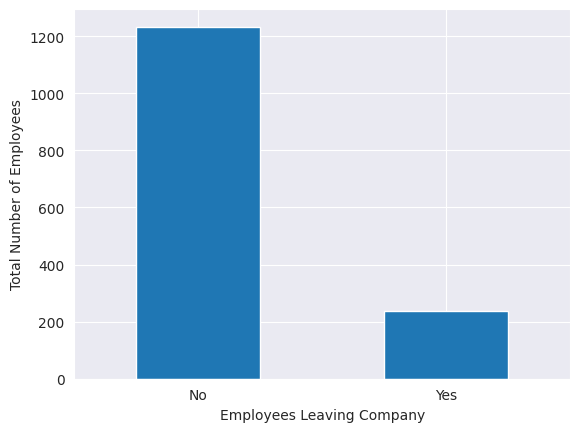

In [ ]:
## BarChart
print(df["Attrition"].value_counts())
df["Attrition"].value_counts().plot(kind="bar")
plt.xlabel('Employees Leaving Company')
plt.ylabel('Total Number of Employees')
plt.xticks(rotation=0);

Text(0.5, 1.0, 'Attrition Distribution')

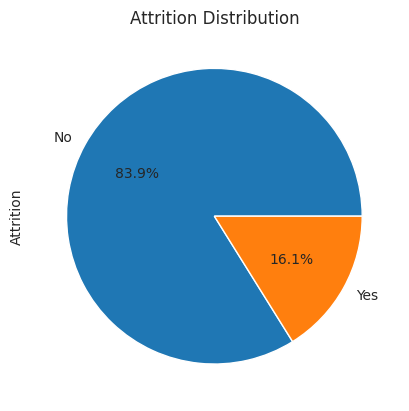

In [ ]:
## PieChart
df['Attrition'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Attrition Distribution')

### Attrition distribution by Age

- The organization has 1470 employees with an average age of 35
- The majority of people who left the company are around 25-32 yrs of age. 
- And after the 35 yrs age, the chances of leaving the company is less even if the majority of people in the company belong to this age group

<Axes: xlabel='Age', ylabel='count'>

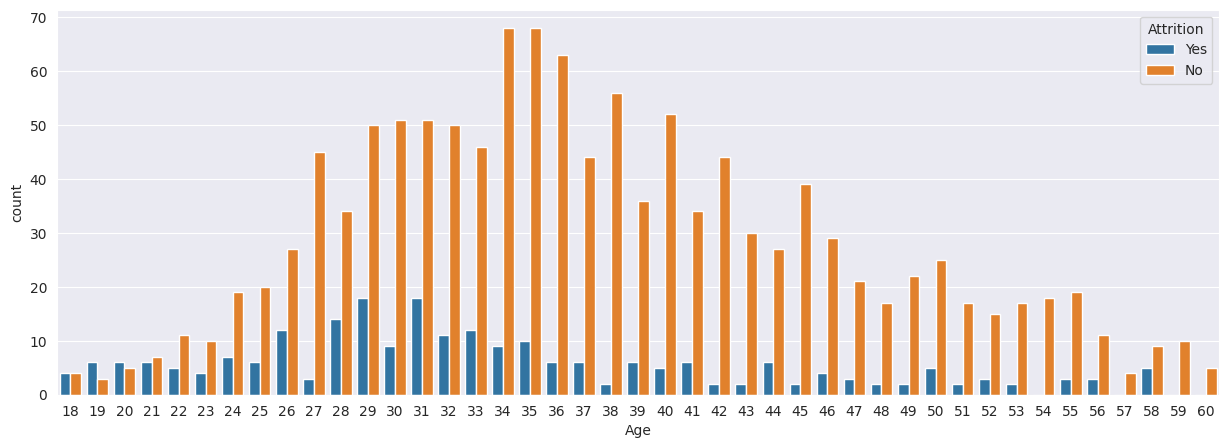

In [ ]:
plt.figure(figsize = [15,5])
sns.countplot(x = 'Age', hue = 'Attrition', data = df)

### Attrition by Monthly Income

- The employees, who have low income, have high attrition rate.

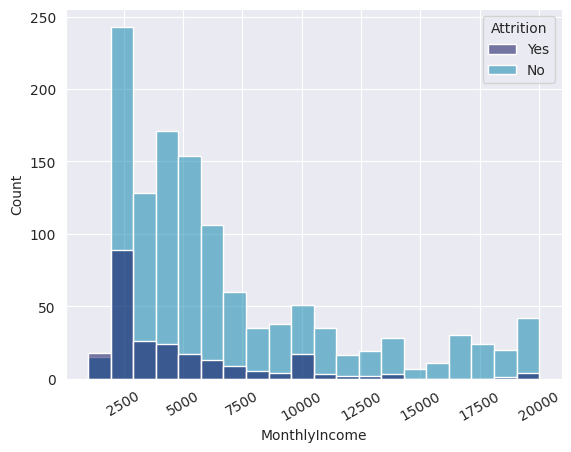

In [ ]:
sns.set_style('darkgrid')
ax = sns.histplot(x='MonthlyIncome', hue='Attrition', data=df, palette='ocean')
plt.sca(ax)
plt.xticks(rotation = 30)
plt.show()

### Attrition per Marital Status

- As expected, the attrition rate for "Single" employees is higher than the Married and Divorced employees.

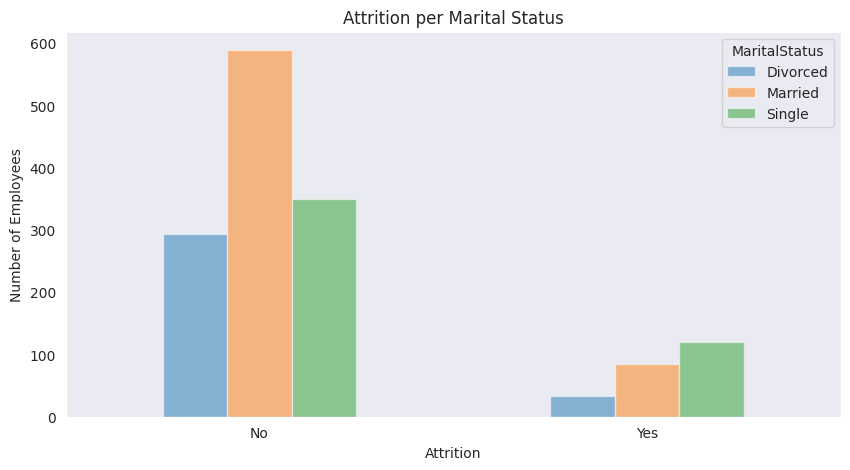

In [ ]:
colors = ['pink', 'lightblue', 'lightgreen']
pd.crosstab(df.Attrition, [df.MaritalStatus]).plot(kind="bar", figsize=(10, 5),alpha=0.5);
plt.title('Attrition per Marital Status')
plt.xlabel('Attrition')
plt.ylabel('Number of Employees')
plt.xticks(rotation=0);
plt.grid(None)

### How Workplace effects Attrition ?

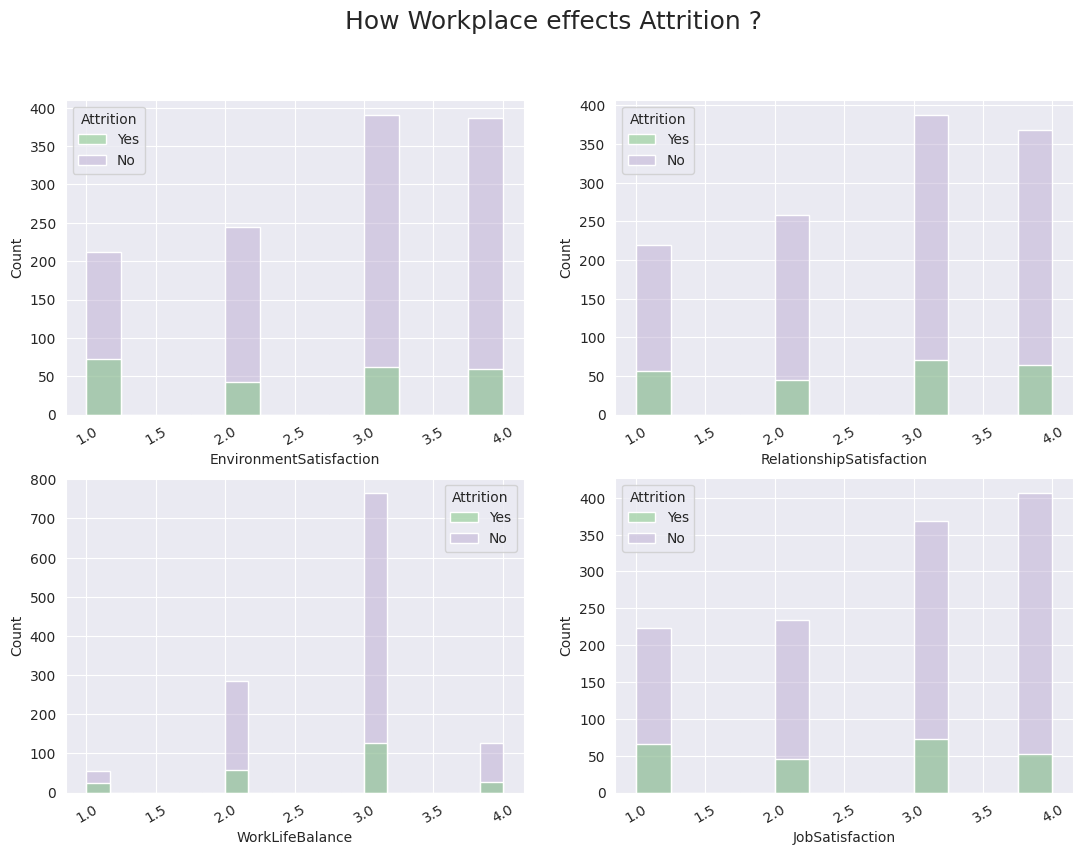

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(13, 9))
plt.suptitle('How Workplace effects Attrition ?', fontsize= 18)
sns.set_style('darkgrid')

ax1 = sns.histplot(x='EnvironmentSatisfaction', hue = 'Attrition', data=df, ax=axs[0, 0], palette='Accent')
ax2 = sns.histplot(x='RelationshipSatisfaction', hue = 'Attrition', data=df, ax=axs[0, 1], palette='Accent')
ax3 = sns.histplot(x='WorkLifeBalance', hue = 'Attrition', data=df, ax=axs[1, 0], palette='Accent')
ax4 = sns.histplot(x='JobSatisfaction', hue = 'Attrition', data=df, ax=axs[1, 1], palette='Accent')

for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 30)
    
plt.show()

In [ ]:
print(sns.__version__)

0.12.2


### Was the work not challenging for the Employee?

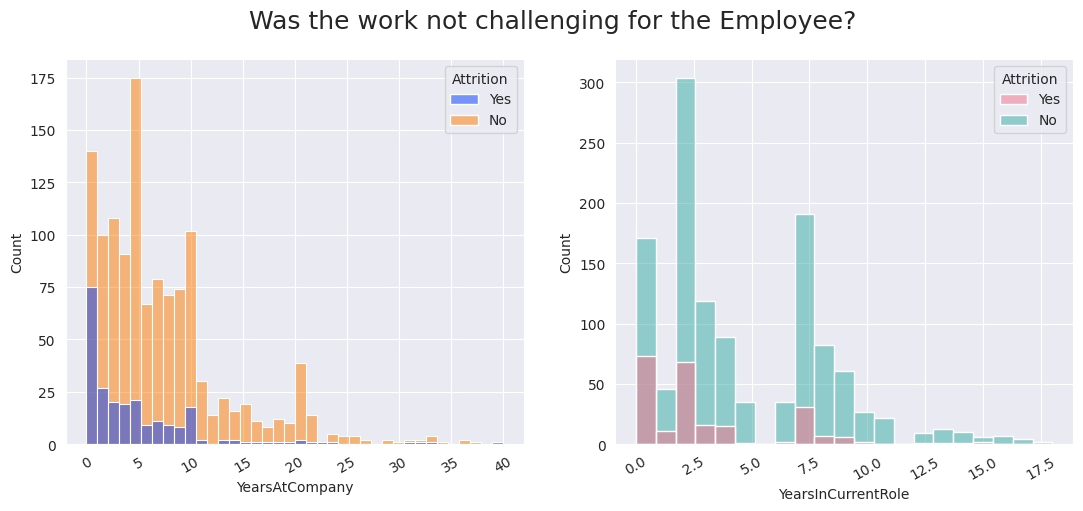

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1,figsize=(13, 5))
plt.suptitle('Was the work not challenging for the Employee?', fontsize= 18)
sns.set_style('darkgrid')

ax1 = sns.histplot(x='YearsAtCompany', hue = 'Attrition', data=df, ax=axs[0], palette='bright')
ax2 = sns.histplot(x='YearsInCurrentRole', hue = 'Attrition', data=df, ax=axs[1], palette='husl')

for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 30)
    
plt.show()

1. Years at Company : Attrition was significantly high on relatively new worker
2. Years at Current Role : Attrtition was significantly high on woker with 0 & 2.5 years at currently

**Identify individuals who have been in a position for a substantial amount of time. The average time a person spends in a role in our organization is around 7 years. We can see that there are some individuals who have been in the same role for more than 15, presenting an opportunity for further investigation.**

### Attrition by "OverTime" working

In [ ]:
## Creating traget variable in binary form (0,1)
df['Attrition_Num'] = np.where(df['Attrition'] == 'Yes',1,0)
df

Age Attrition     BusinessTravel  DailyRate              Department  \
0      41       Yes      Travel_Rarely       1102                   Sales   
1      49        No  Travel_Frequently        279  Research & Development   
2      37       Yes      Travel_Rarely       1373  Research & Development   
3      33        No  Travel_Frequently       1392  Research & Development   
4      27        No      Travel_Rarely        591  Research & Development   
...   ...       ...                ...        ...                     ...   
1465   36        No  Travel_Frequently        884  Research & Development   
1466   39        No      Travel_Rarely        613  Research & Development   
1467   27        No      Travel_Rarely        155  Research & Development   
1468   49        No  Travel_Frequently       1023                   Sales   
1469   34        No      Travel_Rarely        628  Research & Development   

      DistanceFromHome  Education EducationField  EmployeeCount  \
0                    1          2  Life Sciences              1   
1                    8          1  Life Sciences              1   
2                    2          2          Other              1   
3                    3          4  Life Sciences              1   
4                    2          1        Medical              1   
...                ...        ...            ...            ...   
1465                23          2        Medical              1   
1466                 6          1        Medical              1   
1467                 4          3  Life Sciences              1   
1468                 2          3        Medical              1   
1469                 8          3        Medical              1   

      EmployeeNumber  ...  StandardHours StockOptionLevel  TotalWorkingYears  \
0                  1  ...             80                0                  8   
1                  2  ...             80                1                 10   
2                  4  ...             80                0                  7   
3                  5  ...             80                0                  8   
4                  7  ...             80                1                  6   
...              ...  ...            ...              ...                ...   
1465            2061  ...             80                1                 17   
1466            2062  ...             80                1                  9   
1467            2064  ...             80                1                  6   
1468            2065  ...             80                0                 17   
1469            2068  ...             80                0                  6   

      TrainingTimesLastYear  WorkLifeBalance YearsAtCompany  \
0                         0                1              6   
1                         3                3             10   
2                         3                3              0   
3                         3                3              8   
4                         3                3              2   
...                     ...              ...            ...   
1465                      3                3              5   
1466                      5                3              7   
1467                      0                3              6   
1468                      3                2              9   
1469                      3                4              4   

      YearsInCurrentRole YearsSinceLastPromotion  YearsWithCurrManager  \
0                      4                       0                     5   
1                      7                       1                     7   
2                      0                       0                     0   
3                      7                       3                     0   
4                      2                       2                     2   
...                  ...                     ...                   ...   
1465                   2                

In [ ]:
def CategoricalVariables_targetPlots(df1, segment_by,invert_axis = False, target_var = "Attrition_Num"):
    
    """A function for Plotting the effect of variables(categorical data) on attrition """
    
    fig, ax = plt.subplots(ncols= 2, figsize = (14,6))
    
    #countplot for distribution along with target variable
    #invert axis variable helps to inter change the axis so that names of categories doesn't overlap
    if invert_axis == False:
        sns.countplot(x = segment_by, data=df1,hue="Attrition",ax=ax[0])
    else:
        sns.countplot(y = segment_by, data=df1,hue="Attrition",ax=ax[0])
        
    ax[0].set_title("Comparision of " + "Attrition" + " vs " + segment_by)
    
    #plot the effect of variable on attrition
    if invert_axis == False:
        sns.barplot(x = segment_by, y = target_var ,data=df1,ci=None)
    else:
        sns.barplot(y = segment_by, x = target_var ,data=df1,ci=None)
        
    ax[1].set_title("Attrition rate by {}".format(segment_by))
    ax[1].set_ylabel("Average(Attrition)")
    plt.tight_layout()

    plt.show()

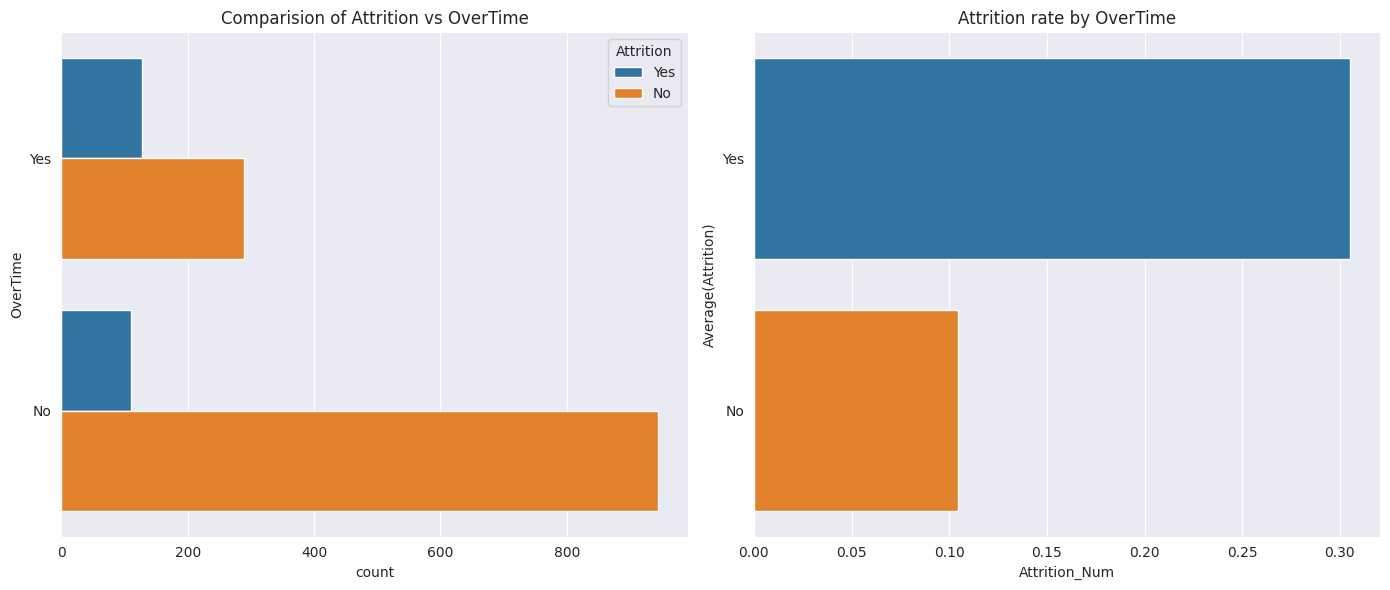

In [ ]:
CategoricalVariables_targetPlots(df,'OverTime',invert_axis=True)

- More than 30% of employee's who worked overtime has left the company, where as 90% of employee's who have not experienced overtime, have not left the company. Therefore overtime is a strong indicator of attrition

### Attrition by "Gender"

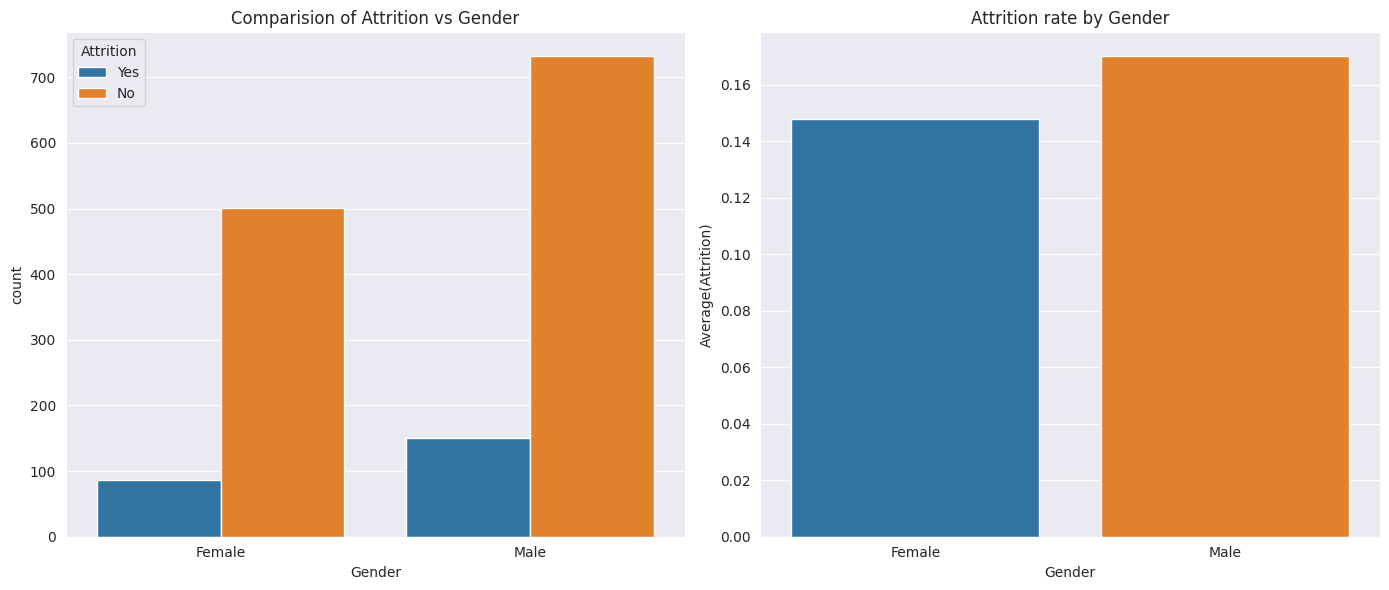

In [ ]:
CategoricalVariables_targetPlots(df,'Gender',invert_axis=False)

- The count for leaving the company is slighly more for Male Employees as compared to Female however, Male population is larger than female population in the company.
- Attrition is not getting effected by "Gender" factor as much.

In [ ]:
df = pd.read_csv('HR-Employee-Attrition.csv')
df.head()
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EnvironmentSatisfaction  \
0                 1          2  Life Sciences                        2   
1                 8          1  Life Sciences                        3   
2                 2          2          Other                        4   
3                 3          4  Life Sciences                        4   
4                 2          1        Medical                        1   

   Gender  ...  PerformanceRating  RelationshipSatisfaction  StockOptionLevel  \
0  Female  ...                  3                         1                 0   
1    Male  ...                  4                         4                 1   
2    Male  ...                  3                         2                 0   
3  Female  ...                  3                         3                 0   
4    Male  ...                  3                         4                 1   

  TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                 8                      0               1               6   
1                10                      3               3              10   
2                 7                      3               3               0   
3                 8                      3               3               8   
4                 6                      3               3               2   

   YearsInCurrentRole  YearsSinceLastPromotion YearsWithCurrManager  
0                   4                        0                    5  
1                   7                        1                    7  
2                   0                        0                    0  
3                   7                        3                    0  
4                   2                        2                    2  

[5 rows x 31 columns]

## Data Preprocessing

### Features with a single value (“EmployeeCount”, “Over18” and “StandardHours”) and the feature related to identity number ('EmployeeNumber') are dropped

In [ ]:
df = pd.read_csv('HR-Employee-Attrition.csv')
df.head()
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EnvironmentSatisfaction  \
0                 1          2  Life Sciences                        2   
1                 8          1  Life Sciences                        3   
2                 2          2          Other                        4   
3                 3          4  Life Sciences                        4   
4                 2          1        Medical                        1   

   Gender  ...  PerformanceRating  RelationshipSatisfaction  StockOptionLevel  \
0  Female  ...                  3                         1                 0   
1    Male  ...                  4                         4                 1   
2    Male  ...                  3                         2                 0   
3  Female  ...                  3                         3                 0   
4    Male  ...                  3                         4                 1   

  TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                 8                      0               1               6   
1                10                      3               3              10   
2                 7                      3               3               0   
3                 8                      3               3               8   
4                 6                      3               3               2   

   YearsInCurrentRole  YearsSinceLastPromotion YearsWithCurrManager  
0                   4                        0                    5  
1                   7                        1                    7  
2                   0                        0                    0  
3                   7                        3                    0  
4                   2                        2                    2  

[5 rows x 31 columns]

### Using both 'Label encoder' and 'One-Hot encoder' to encode the categorical var with numerical value

In [ ]:
df1= df.copy()
Attrition_le = LabelEncoder()
BusinessTravel_le = LabelEncoder()
Gender_le = LabelEncoder()
OverTime_le = LabelEncoder()
onehot = OneHotEncoder(drop='first',sparse=False)


In [ ]:
df1['Attrition'] = Attrition_le.fit_transform(df['Attrition'])
df1['BusinessTravel'] = BusinessTravel_le.fit_transform(df['BusinessTravel'])
df1['Gender'] = Gender_le.fit_transform(df['Gender'])
df1['OverTime'] = OverTime_le.fit_transform(df['OverTime'])

In [ ]:
cate=df1[['Department','EducationField','JobRole','MaritalStatus']]
cate = onehot.fit_transform(cate)
cate = pd.DataFrame(cate, columns = onehot.get_feature_names_out())
cate

Department_Research & Development  Department_Sales  \
0                                   0.0               1.0   
1                                   1.0               0.0   
2                                   1.0               0.0   
3                                   1.0               0.0   
4                                   1.0               0.0   
...                                 ...               ...   
1465                                1.0               0.0   
1466                                1.0               0.0   
1467                                1.0               0.0   
1468                                0.0               1.0   
1469                                1.0               0.0   

      EducationField_Life Sciences  EducationField_Marketing  \
0                              1.0                       0.0   
1                              1.0                       0.0   
2                              0.0                       0.0   
3                              1.0                       0.0   
4                              0.0                       0.0   
...                            ...                       ...   
1465                           0.0                       0.0   
1466                           0.0                       0.0   
1467                           1.0                       0.0   
1468                           0.0                       0.0   
1469                           0.0                       0.0   

      EducationField_Medical  EducationField_Other  \
0                        0.0                   0.0   
1                        0.0                   0.0   
2                        0.0                   1.0   
3                        0.0                   0.0   
4                        1.0                   0.0   
...                      ...                   ...   
1465                     1.0                   0.0   
1466                     1.0                   0.0   
1467                     0.0                   0.0   
1468                     1.0                   0.0   
1469                     1.0                   0.0   

      EducationField_Technical Degree  JobRole_Human Resources  \
0                                 0.0                      0.0   
1                                 0.0                      0.0   
2                                 0.0                      0.0   
3                                 0.0                      0.0   
4                                 0.0                      0.0   
...                               ...                      ...   
1465                              0.0                      0.0   
1466                              0.0                      0.0   
1467                              0.0                      0.0   
1468                              0.0                      0.0   
1469                              0.0                      0.0   

      JobRole_Laboratory Technician  JobRole_Manager  \
0                               0.0              0.0   
1                               0.0              0.0   
2                               1.0              0.0   
3                               0.0              0.0   
4                               1.0              0.0   
...                             ...              ...   
1465                            1.0              0.0   
1466                            0.0              0.0   
1467                            0.0              0.0   
1468                            0.0              0.0   
1469                            1.0              0.0   

      JobRole_Manufacturing Director  JobRole_Research Director  \
0                                0.0                        0.0   
1                                0.0                        0.0   
2                                0.0                        0.0   
3                                0.0                        0.0   
4                                0.0                  

In [ ]:
df1= pd.concat([df1, cate], axis = 1)
df1.drop(['Department','EducationField','JobRole','MaritalStatus'],axis="columns", inplace=True)
df1.head()

Age  Attrition  BusinessTravel  DailyRate  DistanceFromHome  Education  \
0   41          1               2       1102                 1          2   
1   49          0               1        279                 8          1   
2   37          1               2       1373                 2          2   
3   33          0               1       1392                 3          4   
4   27          0               2        591                 2          1   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  ...  \
0                        2       0          94               3  ...   
1                        3       1          61               2  ...   
2                        4       1          92               2  ...   
3                        4       0          56               3  ...   
4                        1       1          40               3  ...   

   JobRole_Human Resources  JobRole_Laboratory Technician  JobRole_Manager  \
0                      0.0                            0.0              0.0   
1                      0.0                            0.0              0.0   
2                      0.0                            1.0              0.0   
3                      0.0                            0.0              0.0   
4                      0.0                            1.0              0.0   

   JobRole_Manufacturing Director  JobRole_Research Director  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0                         0.0                      1.0   
1                         1.0                      0.0   
2                         0.0                      0.0   
3                         1.0                      0.0   
4                         0.0                      0.0   

   JobRole_Sales Representative  MaritalStatus_Married  MaritalStatus_Single  
0                           0.0                    0.0                   1.0  
1                           0.0                    1.0                   0.0  
2                           0.0                    0.0                   1.0  
3                           0.0                    1.0                   0.0  
4                           0.0                    1.0                   0.0  

[5 rows x 44 columns]

### Feature scaling using 'StandardScaler' and train-test split

In [ ]:
y = df1.Attrition
X = df1.drop('Attrition', axis=1)
#X=df1.drop(['Department_Research & Development','EducationField_Life Sciences','JobRole_Sales Executive','JobLevel'], axis="columns", inplace=True)
#y = df1.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22,
                                                    stratify=y)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
X_std = scaler.transform(X)

In [ ]:
y_test.value_counts()[0] / y_test.shape[0]

0.8390022675736961

In [ ]:
stay = (y_train.value_counts()[0] / y_train.shape)[0]
leave = (y_train.value_counts()[1] / y_train.shape)[0]

print("===============TRAIN=================")
print(f"Staying Rate: {stay * 100:.2f}%")
print(f"Leaving Rate: {leave * 100 :.2f}%")

stay = (y_test.value_counts()[0] / y_test.shape)[0]
leave = (y_test.value_counts()[1] / y_test.shape)[0]

print("===============TEST=================")
print(f"Staying Rate: {stay * 100:.2f}%")
print(f"Leaving Rate: {leave * 100 :.2f}%")


===============TRAIN=================
Staying Rate: 83.87%
Leaving Rate: 16.13%
===============TEST=================
Staying Rate: 83.90%
Leaving Rate: 16.10%


## Model Building

### 1.Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_scaled = RandomForestClassifier(
    n_estimators = 100, # number of trees
    max_depth= 5,       # parameters for the individual trees
    oob_score = True,   # whether or not to compute OOB score
    random_state = 0,
    class_weight = 'balanced' #Dealing with imbalanced data using Class weights
)

#fit the model
rf_scaled.fit(X_train_std,y_train)

y_pred = rf_scaled.predict(X_test_std)
print("RESULTS: \n===============================")
clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
print(f"balanced accuracy score:\n{balanced_accuracy_score(y_test, y_pred):.4f}")
print(f'AUC score:\n{roc_auc_score(y_test, y_pred):.4f}')
print(f"CLASSIFICATION REPORT:\n{clf_report}")

RESULTS: 
CONFUSION MATRIX:
[[336  34]
 [ 29  42]]
balanced accuracy score:
0.7498
AUC score:
0.7498
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.920548   0.552632  0.857143    0.736590      0.861314
recall       0.908108   0.591549  0.857143    0.749829      0.857143
f1-score     0.914286   0.571429  0.857143    0.742857      0.859086
support    370.000000  71.000000  0.857143  441.000000    441.000000


the confusion matrix Random Forest based on the first task is:


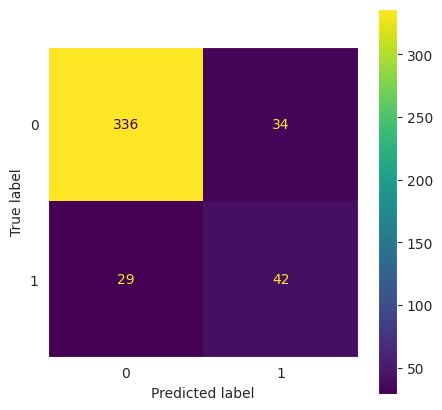

In [ ]:
print('the confusion matrix Random Forest based on the first task is:')
fig, _ = plt.subplots(nrows=1, figsize=(5,5))
ax = plt.subplot(1, 1, 1)
ax.grid(False)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=[0,1]), display_labels=[0,1])
disp.plot(ax=ax)

In [ ]:
#list for the feature importance
columns=['importance']
rf_scaled_feature_importances = pd.DataFrame(rf_scaled.feature_importances_, index = X.columns,columns=columns).sort_values(by='importance',ascending = False)
rf_scaled_feature_importances

importance
MonthlyIncome                        0.090808
OverTime                             0.087735
StockOptionLevel                     0.081743
JobLevel                             0.067733
TotalWorkingYears                    0.064702
Age                                  0.056715
YearsAtCompany                       0.040389
DailyRate                            0.037032
DistanceFromHome                     0.036013
HourlyRate                           0.035132
MonthlyRate                          0.032957
MaritalStatus_Single                 0.027991
JobSatisfaction                      0.027081
YearsInCurrentRole                   0.025736
PercentSalaryHike                    0.025107
YearsSinceLastPromotion              0.024198
NumCompaniesWorked                   0.023792
EnvironmentSatisfaction              0.023456
YearsWithCurrManager                 0.021469
JobInvolvement                       0.017885
WorkLifeBalance                      0.016659
TrainingTimesLastYear                0.015554
RelationshipSatisfaction             0.013317
Education                            0.012868
Department_Research & Development    0.009080
BusinessTravel                       0.007723
JobRole_Sales Executive              0.007611
JobRole_Manufacturing Director       0.007597
MaritalStatus_Married                0.006211
JobRole_Research Scientist           0.005771
Department_Sales                     0.005435
EducationField_Technical Degree      0.005230
EducationField_Medical               0.004947
JobRole_Research Director            0.004341
Gender                               0.004224
JobRole_Sales Representative         0.003957
JobRole_Manager                      0.003875
JobRole_Laboratory Technician        0.003775
EducationField_Life Sciences         0.003609
EducationField_Marketing             0.003603
PerformanceRating                    0.003304
JobRole_Human Resources              0.001879
EducationField_Other                 0.001756

Text(0.5, 0, 'Importance')

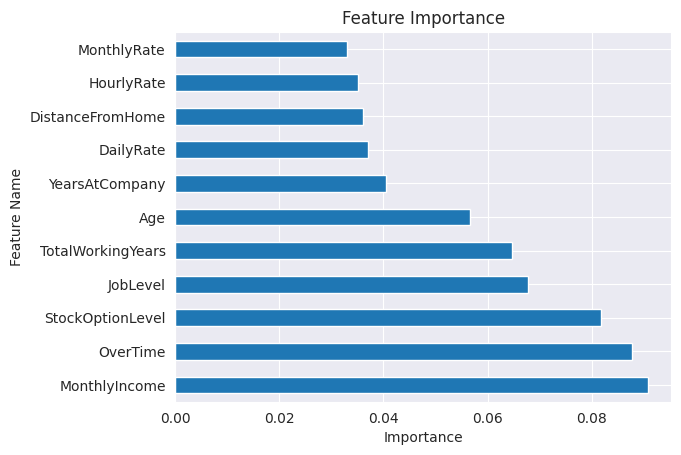

In [ ]:
rf_scaled_feature_importances['importance'].iloc[0:11].plot(kind="barh")
plt.title("Feature Importance")
plt.ylabel("Feature Name")
plt.xlabel("Importance")

### 2.XGBoost Model

In [ ]:
## 2. Gradient Boosting

In [ ]:
xgb = XGBClassifier(
    n_estimators = 500,   # Number of trees i.e. number of boosting steps to take
    learning_rate = 0.1,  # Learning rate. Set this to a small number to grow trees slowly.
    max_depth = 1,        # Parameters for the individual trees
    random_state= 22
)

In [ ]:
#fit the model
xgb.fit(X_train_std,y_train)

y_pred = xgb.predict(X_test_std)
print("XGB RESULTS: \n===============================")
clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
print(f"balanced accuracy score:\n{balanced_accuracy_score(y_test, y_pred):.4f}")
print(f'AUC score:\n{roc_auc_score(y_test, y_pred):.4f}')
print(f"CLASSIFICATION REPORT:\n{clf_report}")

XGB RESULTS: 
CONFUSION MATRIX:
[[365   5]
 [ 39  32]]
balanced accuracy score:
0.7186
AUC score:
0.7186
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.903465   0.864865  0.900227    0.884165      0.897251
recall       0.986486   0.450704  0.900227    0.718595      0.900227
f1-score     0.943152   0.592593  0.900227    0.767873      0.886713
support    370.000000  71.000000  0.900227  441.000000    441.000000


the confusion matrix Random Forest based on the first task is:


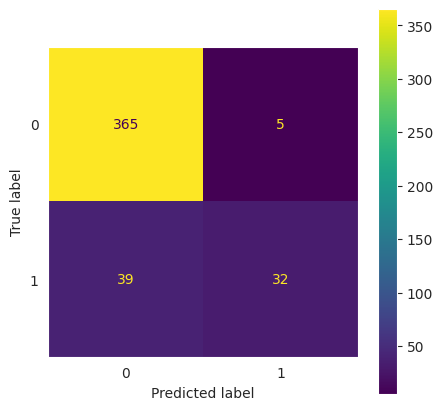

In [ ]:
print('the confusion matrix Random Forest based on the first task is:')
fig, _ = plt.subplots(nrows=1, figsize=(5,5))
ax = plt.subplot(1, 1, 1)
ax.grid(False)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=[0,1]), display_labels=[0,1])
disp.plot(ax=ax)

In [ ]:
#list for the feature importance
columns=['importance']
xgb_feature_importances = pd.DataFrame(xgb.feature_importances_, index = X.columns,columns=columns).sort_values(by='importance',ascending = False)
xgb_feature_importances

importance
JobLevel                             0.098963
OverTime                             0.093751
StockOptionLevel                     0.080817
YearsAtCompany                       0.069491
TotalWorkingYears                    0.049779
EnvironmentSatisfaction              0.049369
JobSatisfaction                      0.046055
Department_Research & Development    0.042811
MonthlyIncome                        0.037370
DistanceFromHome                     0.035778
NumCompaniesWorked                   0.034106
JobInvolvement                       0.032256
RelationshipSatisfaction             0.031033
WorkLifeBalance                      0.029989
Age                                  0.028426
YearsSinceLastPromotion              0.024306
TrainingTimesLastYear                0.023077
YearsWithCurrManager                 0.022023
JobRole_Research Scientist           0.019830
Gender                               0.019081
BusinessTravel                       0.018951
EducationField_Technical Degree      0.017895
MaritalStatus_Single                 0.017110
DailyRate                            0.015212
PercentSalaryHike                    0.014759
JobRole_Laboratory Technician        0.012481
MonthlyRate                          0.012294
HourlyRate                           0.011620
Department_Sales                     0.011368
JobRole_Manager                      0.000000
MaritalStatus_Married                0.000000
JobRole_Sales Representative         0.000000
JobRole_Sales Executive              0.000000
JobRole_Research Director            0.000000
JobRole_Manufacturing Director       0.000000
YearsInCurrentRole                   0.000000
Education                            0.000000
JobRole_Human Resources              0.000000
EducationField_Other                 0.000000
EducationField_Medical               0.000000
PerformanceRating                    0.000000
EducationField_Life Sciences         0.000000
EducationField_Marketing             0.000000

Text(0.5, 0, 'Importance')

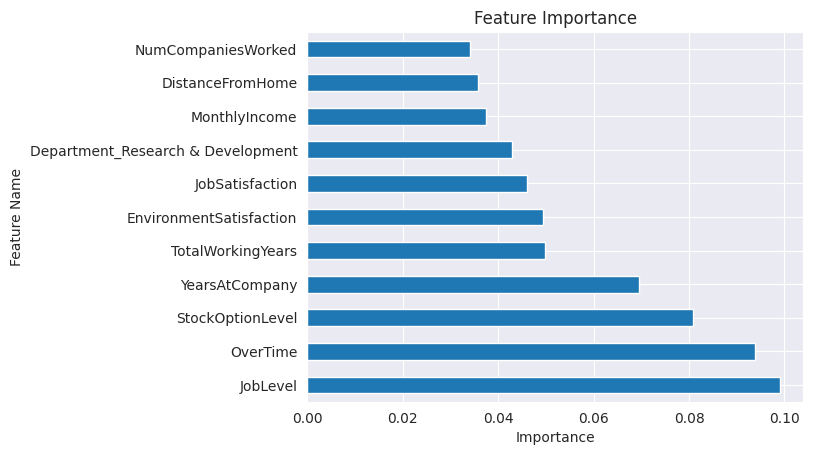

In [ ]:
xgb_feature_importances['importance'].iloc[0:11].plot(kind="barh")
plt.title("Feature Importance")
plt.ylabel("Feature Name")
plt.xlabel("Importance")

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
perm = PermutationImportance(rf_scaled.fit(X_test_std,y_test), 
                             random_state=1).fit(X_test_std,y_test)
eli5.show_weights(perm, 
                  feature_names = X_test.columns.tolist(), 
                  top=(44))

In [ ]:
perm = PermutationImportance(xgb.fit(X_test_std,y_test), 
                             random_state=1).fit(X_test_std,y_test)
eli5.show_weights(perm, 
                  feature_names = X_test.columns.tolist(), 
                  top=(44))

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation feature importance on validation set
perm_importance = permutation_importance(rf_scaled, X_test_std, y_test, n_repeats=1, random_state=0)

# Sort feature importance scores in descending order
sorted_importances = sorted(zip(X_test.columns, perm_importance.importances_mean), key=lambda x: x[1], reverse=True)

# Print sorted feature importance scores
for feature, score in sorted_importances:
    print(f'{feature}: {score}')
print('\n')

# Select features based on importance scores
selected_features = X_test.columns[perm_importance.importances_mean > 0]

#define train and test data with scaling on selected features
X_train_new = X_train[selected_features]
X_train_perm = scaler.fit_transform(X_train_new)
X_test_new = X_test[selected_features]
X_test_perm = scaler.fit_transform(X_test_new)

# Train a new model with selected features on training set
rf_scaled2 = RandomForestClassifier(
    n_estimators = 100, # number of trees
    max_depth= 5,       # parameters for the individual trees
    oob_score = True,   # whether or not to compute OOB score
    random_state = 0,
    class_weight = 'balanced' #Dealing with imbalanced data using Class weights
)
rf_scaled2.fit(X_train_perm, y_train)
y_pred_perm = rf_scaled2.predict(X_test_perm)

#Evaluate model performance before feature selection
y_pred = rf_scaled.predict(X_test_std)
BAS_before_rf = balanced_accuracy_score(y_test, y_pred)

# Evaluate model performance on test set with selected features
BAS_after_rf = balanced_accuracy_score(y_test, y_pred_perm)
print('Test set balanced accuracy after feature selection:', BAS_after_rf)

# Compute decrease in model performance on test set
test_acc_decrease = BAS_before_rf - BAS_after_rf
print('Decrease in test set accuracy:', test_acc_decrease)



OverTime: 0.04308390022675734
MonthlyIncome: 0.015873015873015928
TrainingTimesLastYear: 0.0113378684807256
HourlyRate: 0.009070294784580546
TotalWorkingYears: 0.009070294784580546
YearsInCurrentRole: 0.009070294784580546
Department_Sales: 0.009070294784580546
Age: 0.006802721088435382
DistanceFromHome: 0.006802721088435382
JobLevel: 0.006802721088435382
PercentSalaryHike: 0.006802721088435382
YearsAtCompany: 0.006802721088435382
YearsSinceLastPromotion: 0.006802721088435382
MaritalStatus_Single: 0.006802721088435382
BusinessTravel: 0.0045351473922902175
DailyRate: 0.0045351473922902175
JobSatisfaction: 0.0045351473922902175
MonthlyRate: 0.0045351473922902175
RelationshipSatisfaction: 0.0045351473922902175
StockOptionLevel: 0.0045351473922902175
WorkLifeBalance: 0.0045351473922902175
YearsWithCurrManager: 0.0045351473922902175
Department_Research & Development: 0.0045351473922902175
EducationField_Other: 0.0045351473922902175
JobRole_Laboratory Technician: 0.0045351473922902175
JobRole

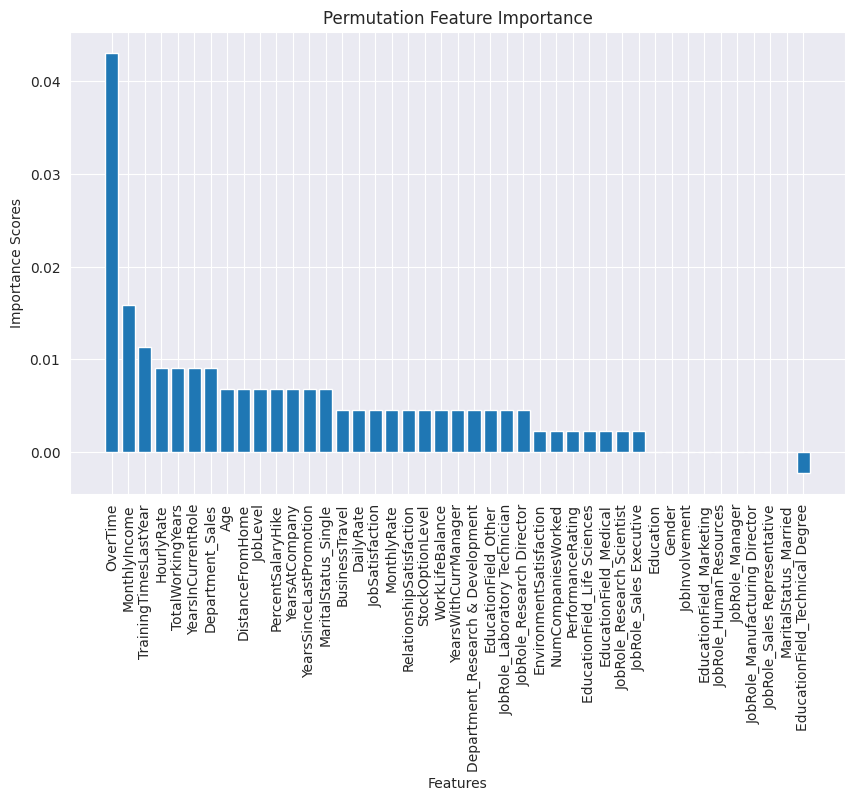

In [ ]:
# Extract feature names and scores
features = [x[0] for x in sorted_importances]
scores = [x[1] for x in sorted_importances]

# Plot the feature importance scores
plt.figure(figsize=(10,6))
plt.bar(features, scores)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Permutation Feature Importance')
plt.show()

In [ ]:
# Compute permutation feature importance on validation set
perm_importance = permutation_importance(xgb, X_test_std, y_test, n_repeats=10, random_state=0)

# Sort feature importance scores in descending order
sorted_importances = sorted(zip(X_test.columns, perm_importance.importances_mean), key=lambda x: x[1], reverse=True)

# Print sorted feature importance scores
for feature, score in sorted_importances:
    print(f'{feature}: {score}')
print('\n')

# Select features based on importance scores
selected_features = X_test.columns[perm_importance.importances_mean > 0]

#define train and test data with scaling on selected features
X_train_new = X_train[selected_features]
X_train_perm = scaler.fit_transform(X_train_new)
X_test_new = X_test[selected_features]
X_test_perm = scaler.fit_transform(X_test_new)

# Train a new model with selected features on training set
xgb2 = XGBClassifier(
    n_estimators = 500,   # Number of trees i.e. number of boosting steps to take
    learning_rate = 0.1,  # Learning rate. Set this to a small number to grow trees slowly.
    max_depth = 1,        # Parameters for the individual trees
    random_state= 22
)
xgb2.fit(X_train_perm, y_train)
y_pred_perm = xgb2.predict(X_test_perm)

#Evaluate model performance before feature selection
y_pred = xgb.predict(X_test_std)
BAS_before_xgb = balanced_accuracy_score(y_test, y_pred)

# Evaluate model performance on test set with selected features
BAS_after_xgb = balanced_accuracy_score(y_test, y_pred_perm)
print('Test set balanced accuracy after feature selection:', BAS_after_xgb)

# Compute decrease in model performance on test set
test_acc_decrease = BAS_before_xgb - BAS_after_xgb
print('Decrease in test set accuracy:', test_acc_decrease)

OverTime: 0.043537414965986364
YearsWithCurrManager: 0.02426303854875279
EnvironmentSatisfaction: 0.01927437641723353
Age: 0.017913832199546453
MonthlyIncome: 0.017233560090702916
NumCompaniesWorked: 0.008163265306122403
EducationField_Marketing: 0.006122448979591799
TrainingTimesLastYear: 0.005895691609977294
JobSatisfaction: 0.005895691609977283
YearsInCurrentRole: 0.005668934240362777
YearsAtCompany: 0.00498866213151925
BusinessTravel: 0.0045351473922902175
JobRole_Research Scientist: 0.003628117913832163
EducationField_Technical Degree: 0.00317460317460313
RelationshipSatisfaction: 0.002040816326530581
DistanceFromHome: 0.00204081632653057
JobRole_Research Director: 0.00204081632653057
JobInvolvement: 0.0011337868480725266
Department_Research & Development: 0.0011337868480725266
Department_Sales: 0.0006802721088435048
StockOptionLevel: 0.00022675736961448313
DailyRate: 0.00022675736961447202
Education: 0.0
Gender: 0.0
PercentSalaryHike: 0.0
PerformanceRating: 0.0
EducationField_Med

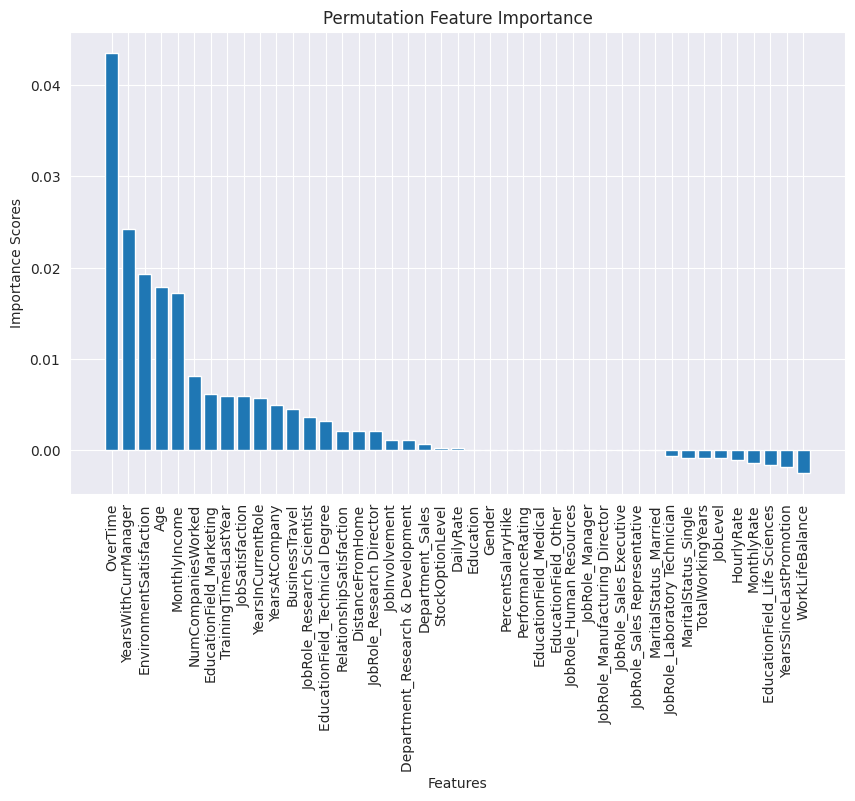

In [ ]:
# Extract feature names and scores
features = [x[0] for x in sorted_importances]
scores = [x[1] for x in sorted_importances]

# Plot the feature importance scores
plt.figure(figsize=(10,6))
plt.bar(features, scores)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Permutation Feature Importance')
plt.show()

# Partial Dependence Plots (PDP)

Age


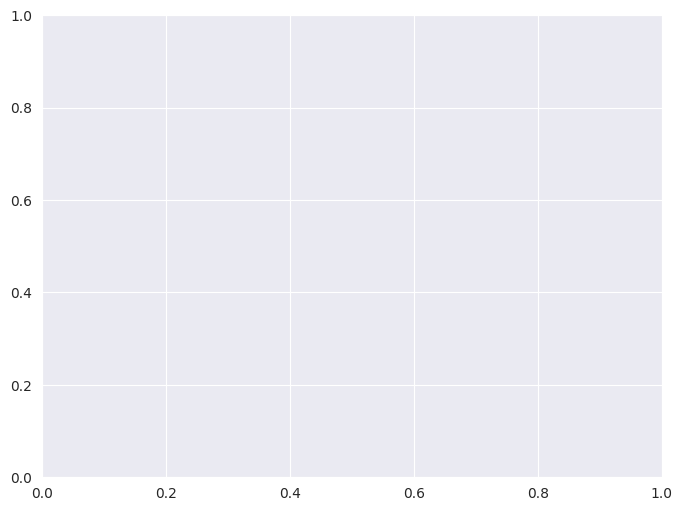

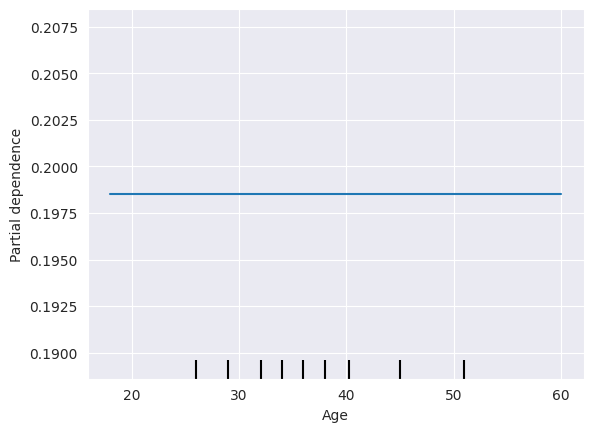

BusinessTravel


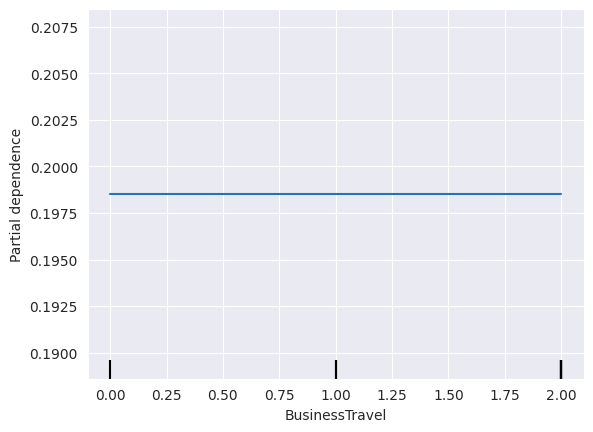

DailyRate


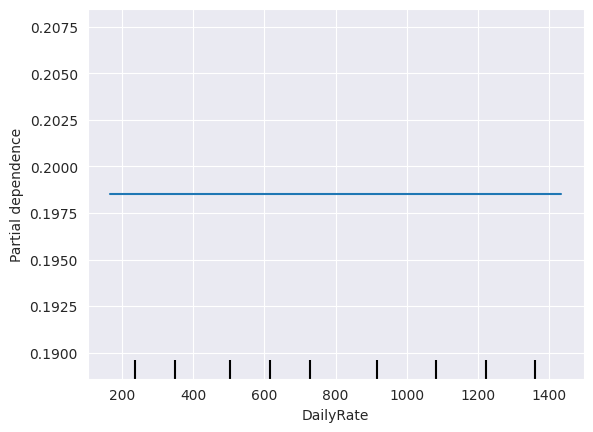

DistanceFromHome


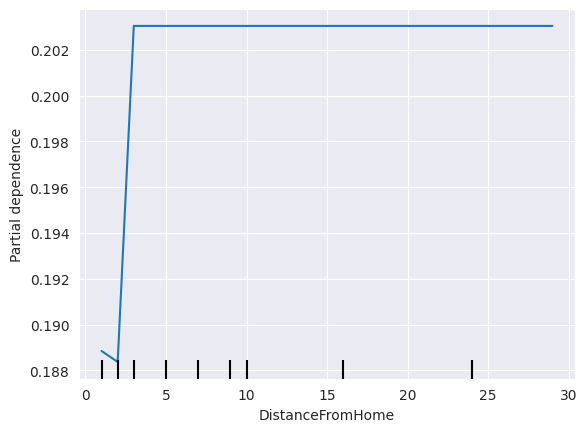

Education


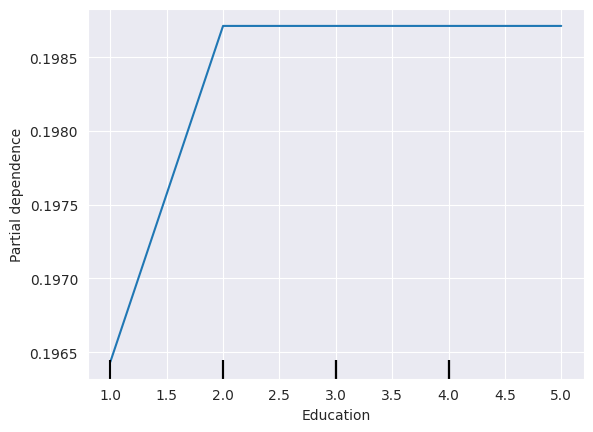

EnvironmentSatisfaction


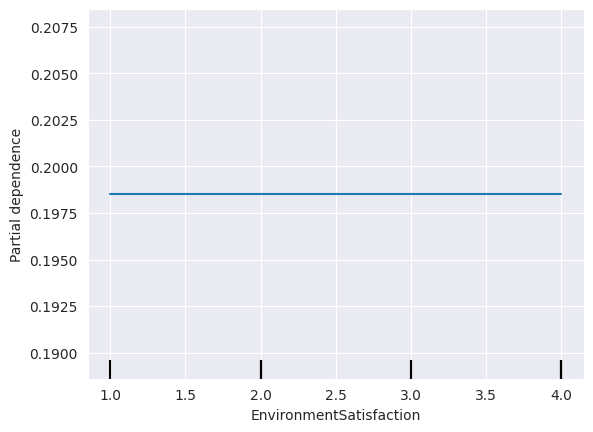

Gender


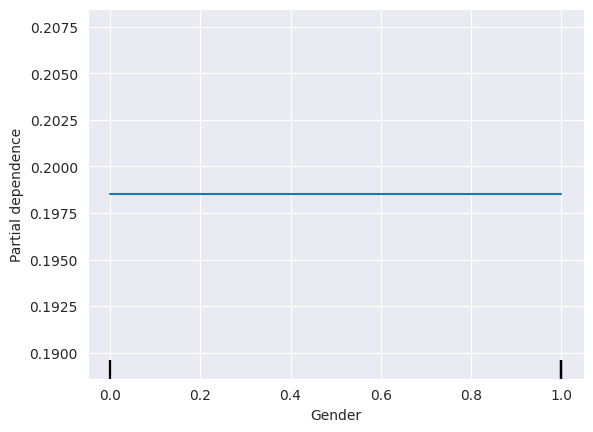

HourlyRate


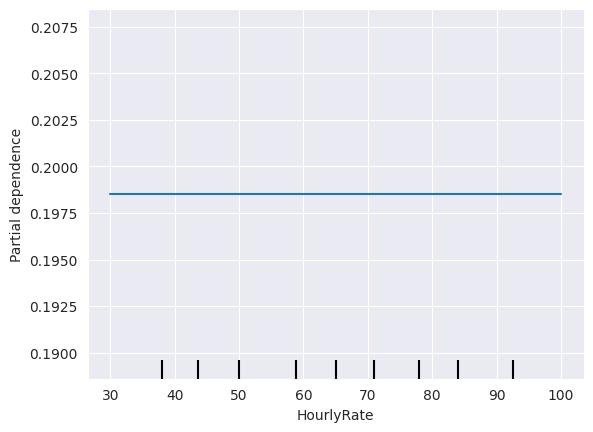

JobInvolvement


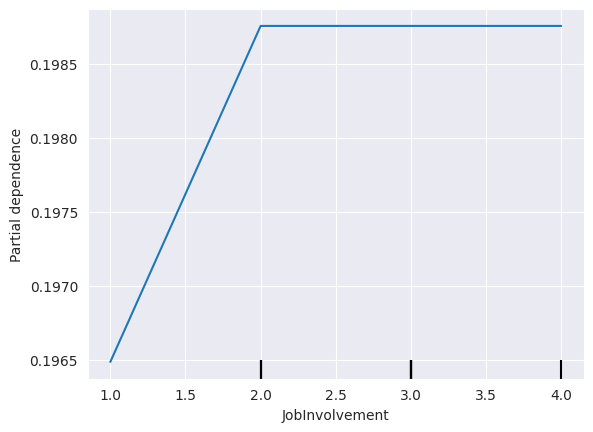

JobLevel


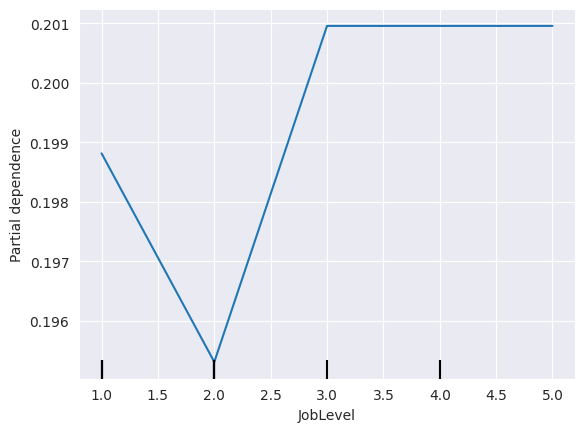

JobSatisfaction


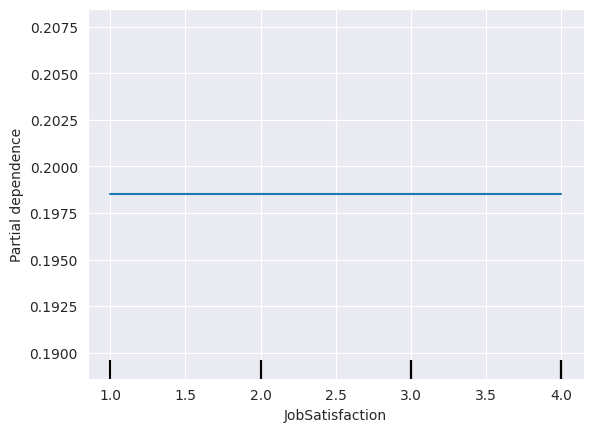

MonthlyIncome


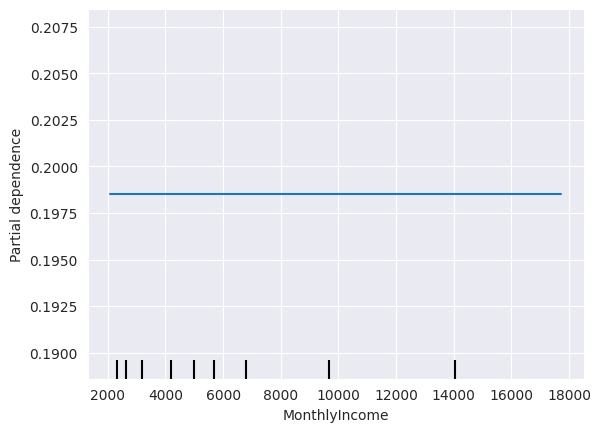

MonthlyRate


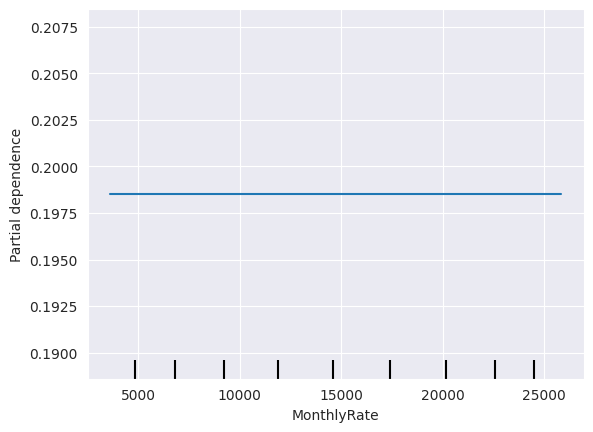

NumCompaniesWorked


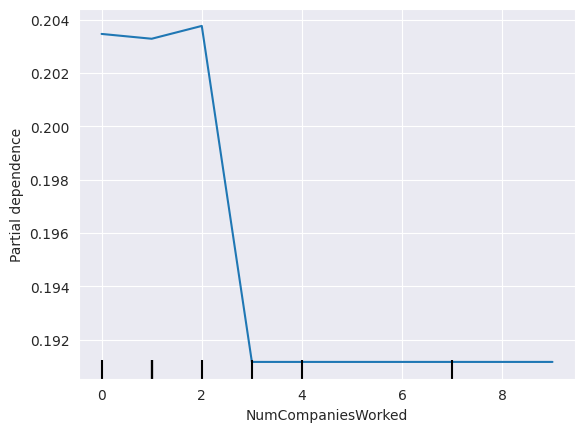

OverTime


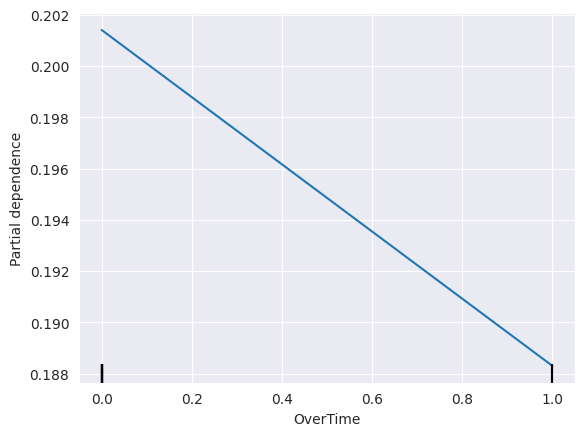

PercentSalaryHike


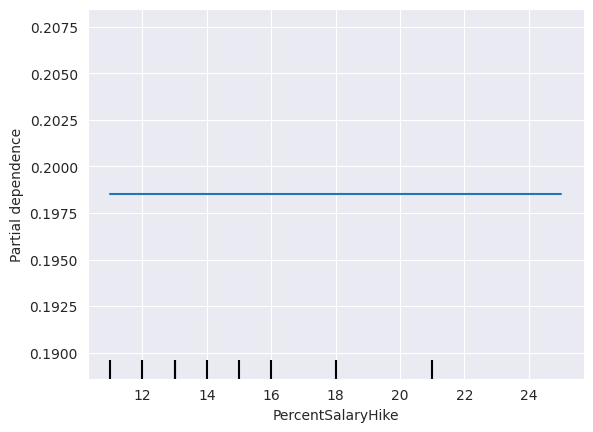

PerformanceRating


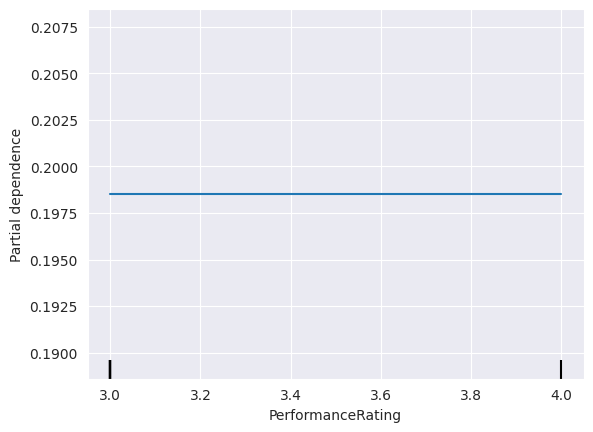

RelationshipSatisfaction


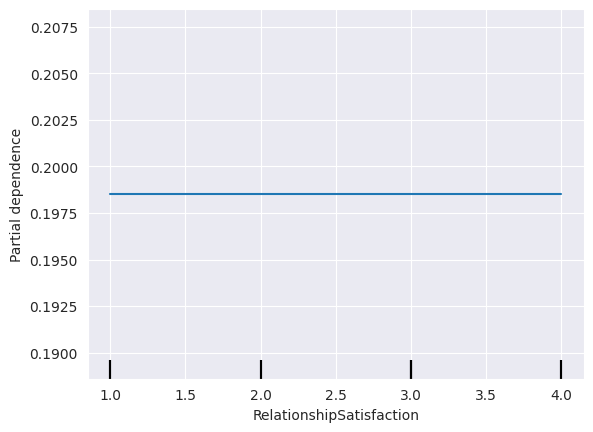

StockOptionLevel


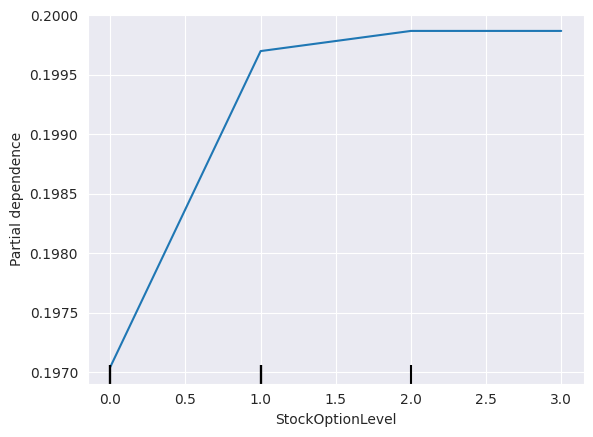

TotalWorkingYears


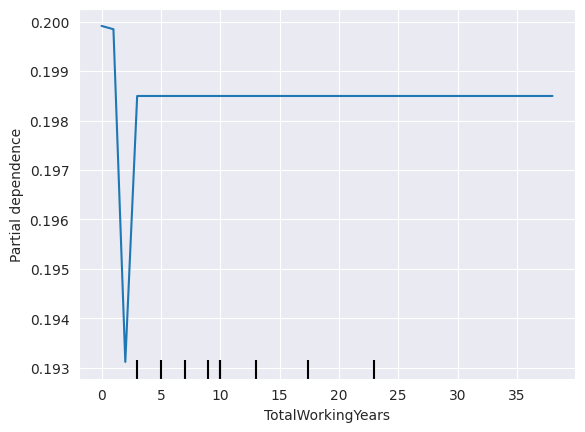

TrainingTimesLastYear


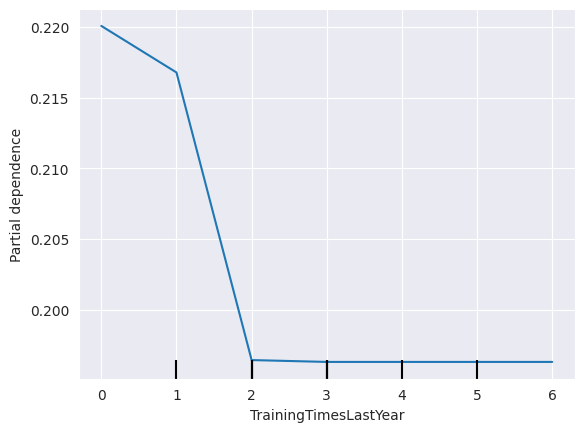

WorkLifeBalance


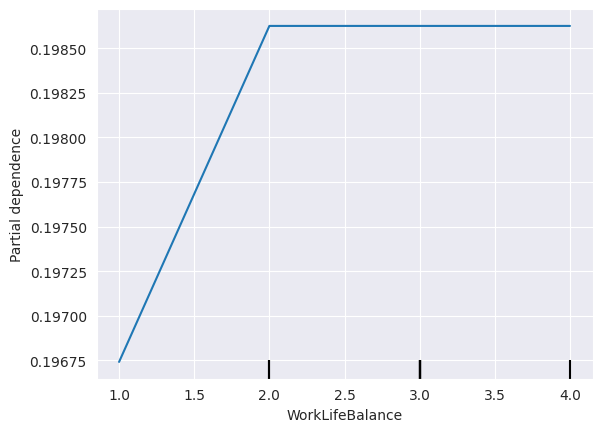

YearsAtCompany


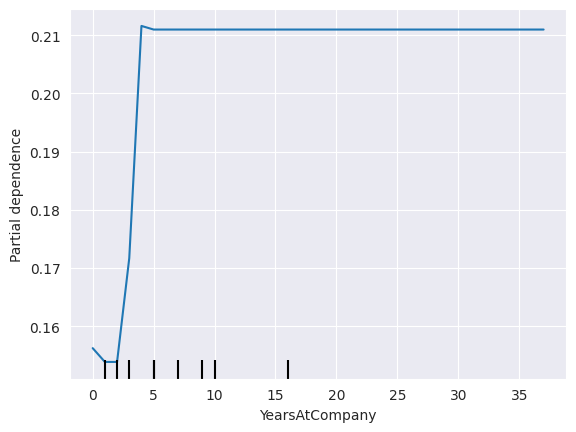

YearsInCurrentRole


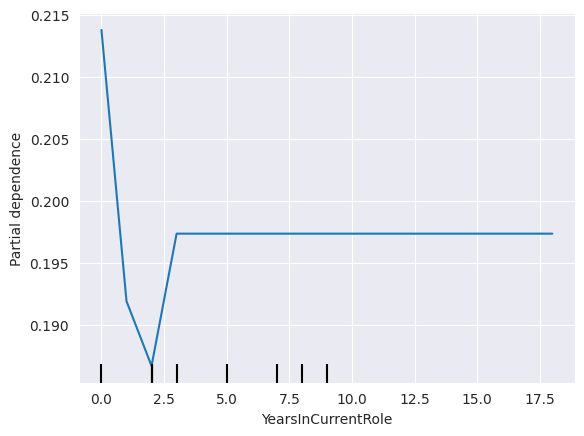

YearsSinceLastPromotion


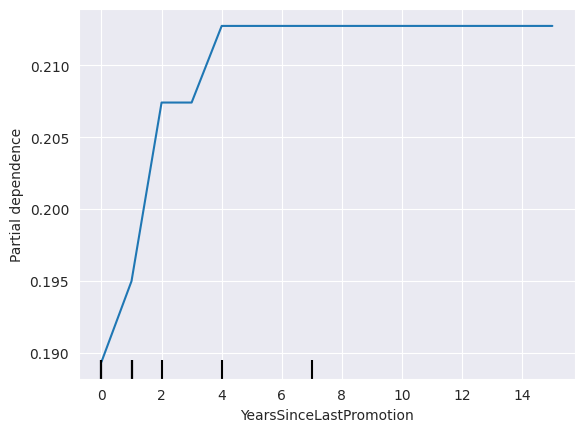

YearsWithCurrManager


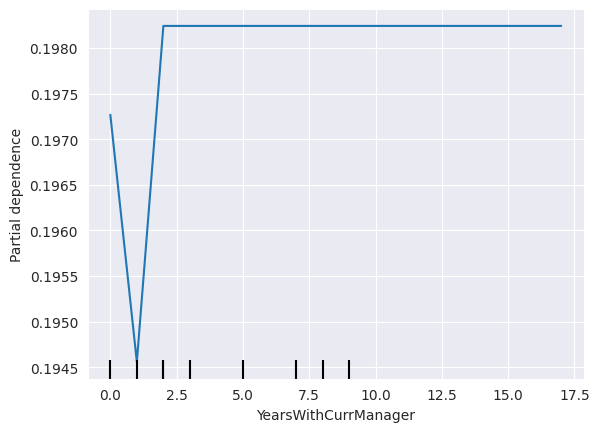

Department_Research & Development


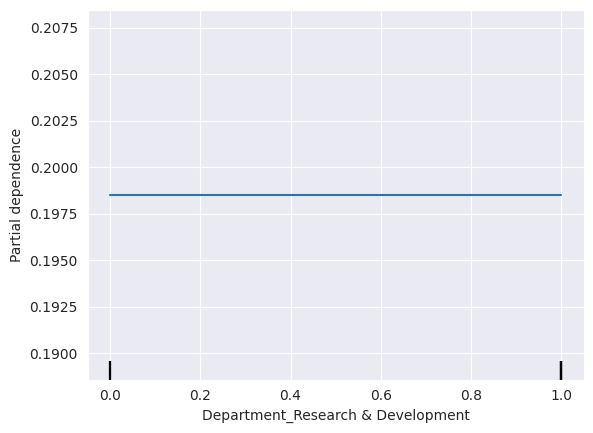

Department_Sales


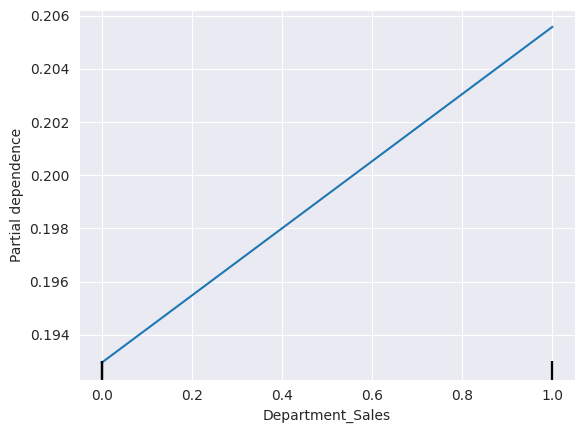

EducationField_Life Sciences


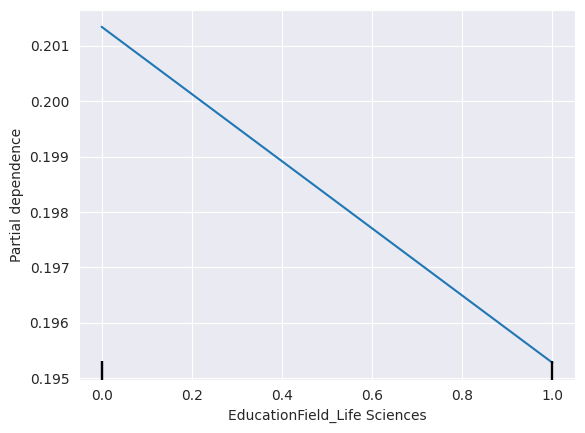

EducationField_Marketing


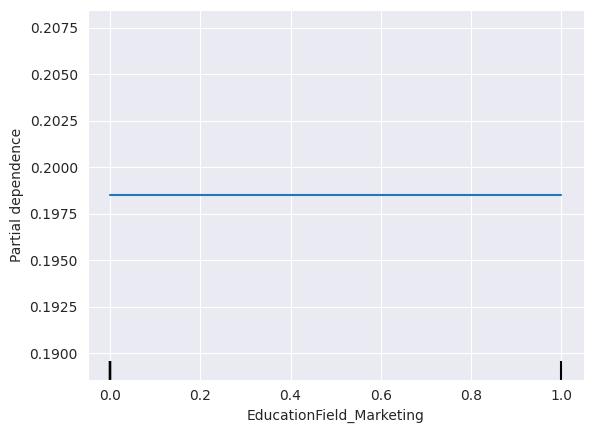

EducationField_Medical


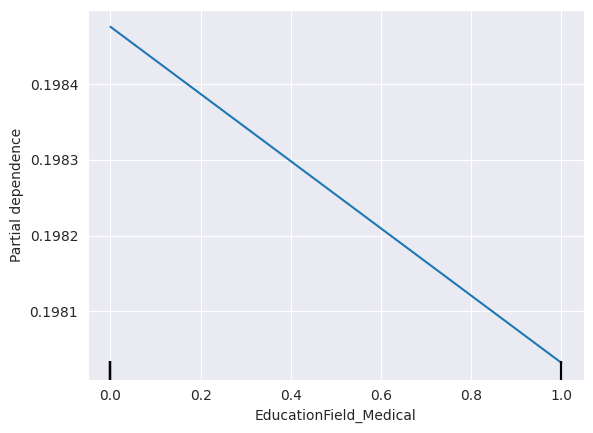

EducationField_Other


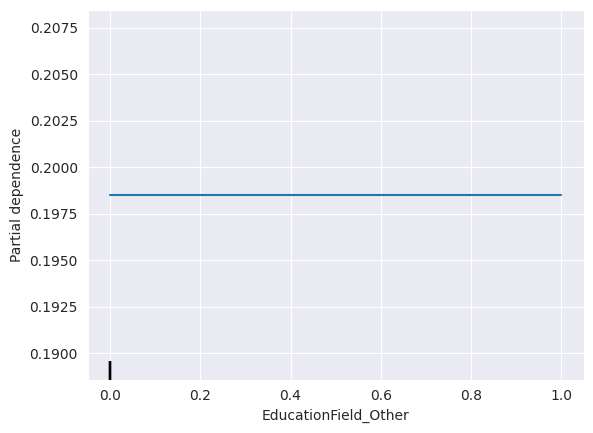

EducationField_Technical Degree


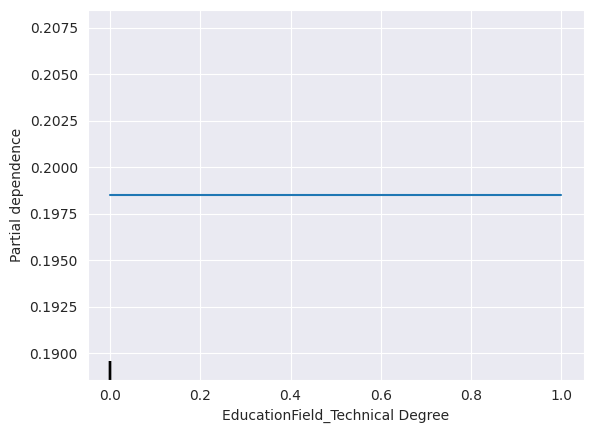

JobRole_Human Resources


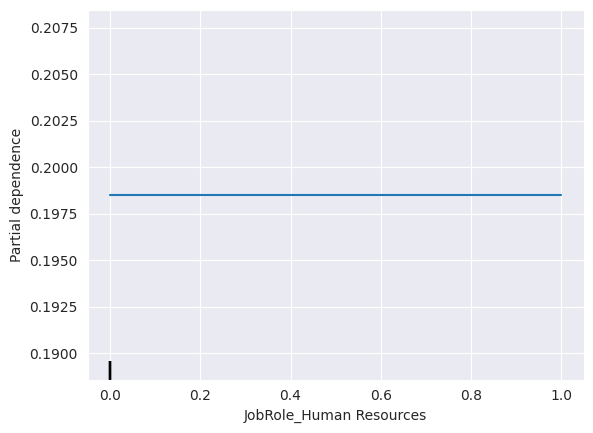

JobRole_Laboratory Technician


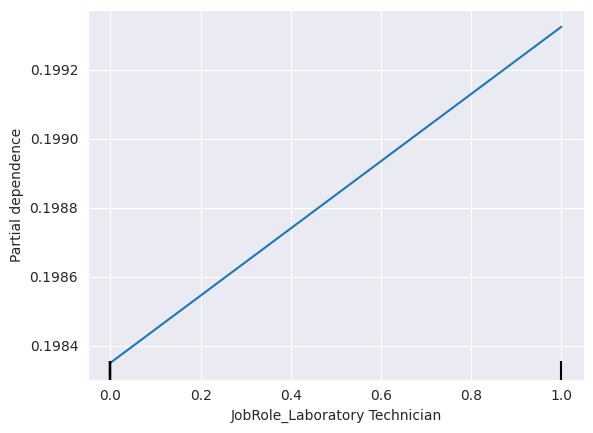

JobRole_Manager


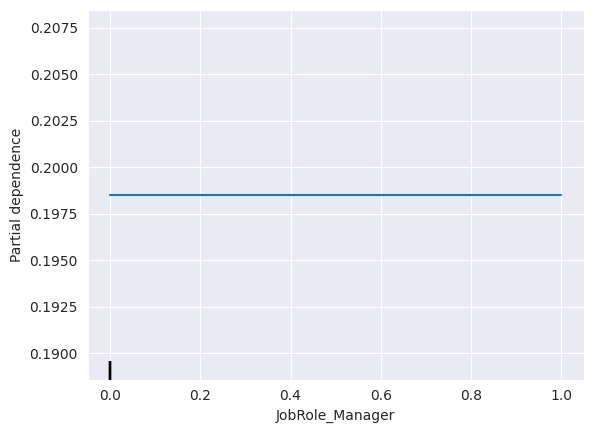

JobRole_Manufacturing Director


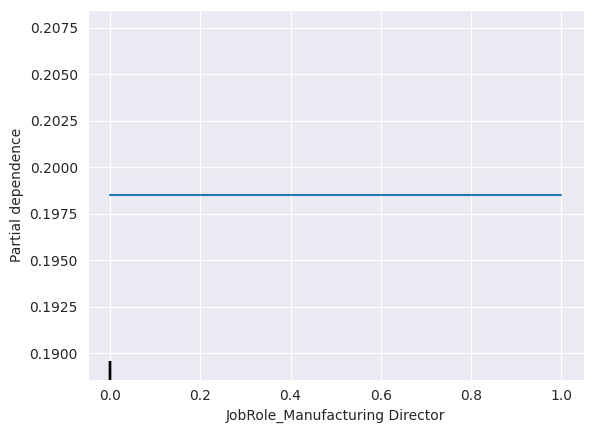

JobRole_Research Director


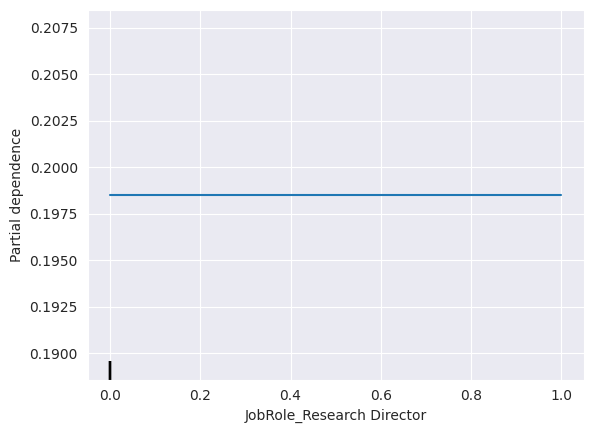

JobRole_Research Scientist


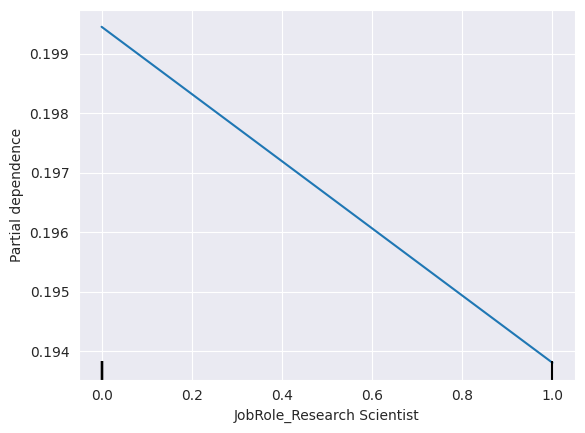

JobRole_Sales Executive


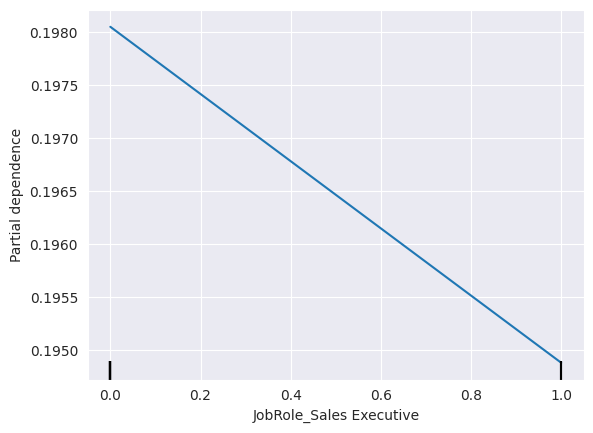

JobRole_Sales Representative


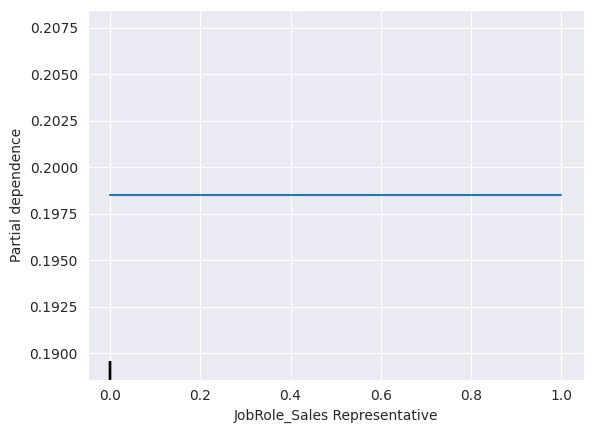

MaritalStatus_Married


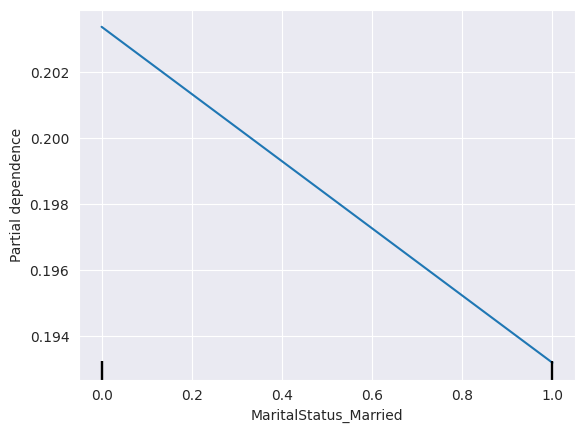

MaritalStatus_Single


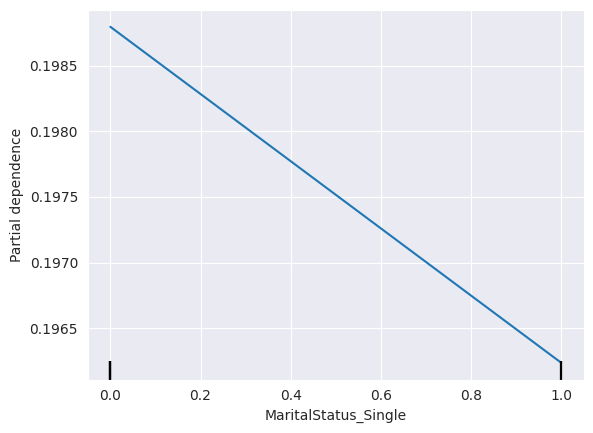

In [ ]:
# random forest model
fig, ax = plt.subplots(figsize=(8, 6))
for feat_name in X_train.columns:
    print(feat_name)
    PartialDependenceDisplay.from_estimator(rf_scaled, X_test, [feat_name])
    pic_name = "rf_"+feat_name+"_dependency.png"
    plt.savefig(pic_name)
    plt.show()

Age


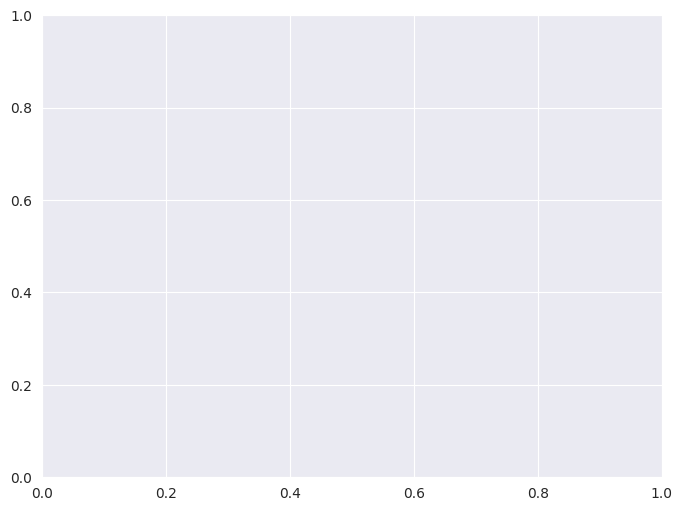

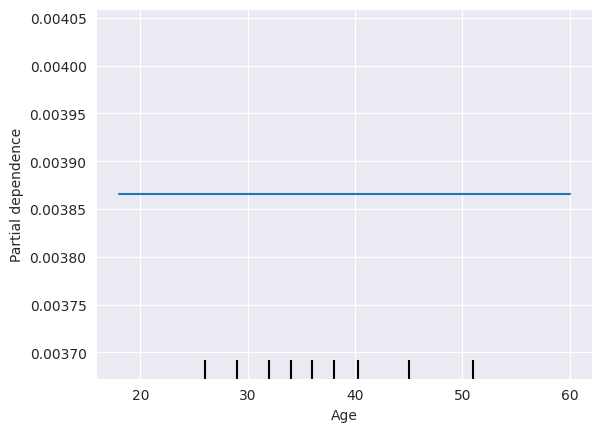

BusinessTravel


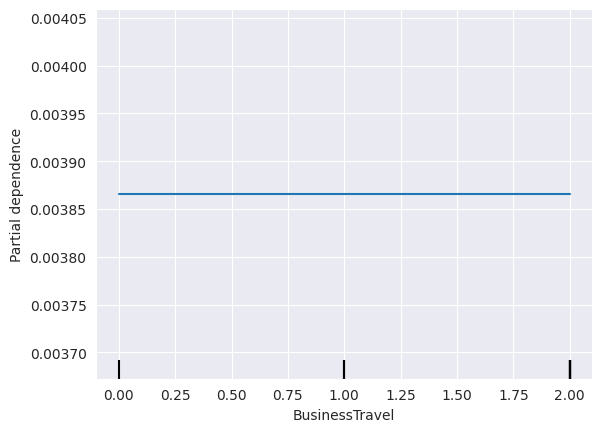

DailyRate


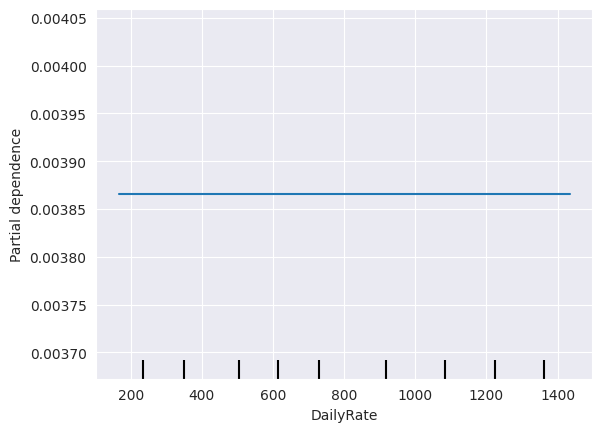

DistanceFromHome


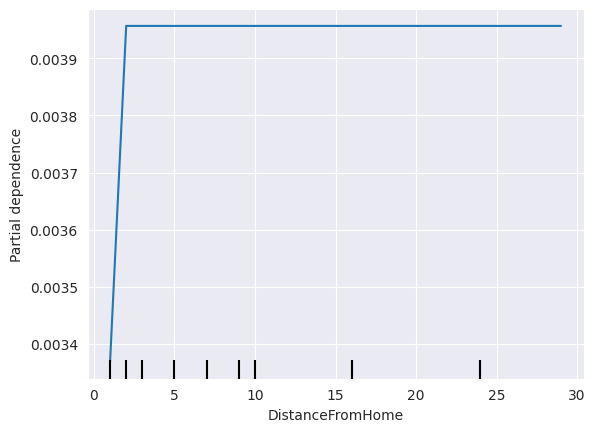

Education


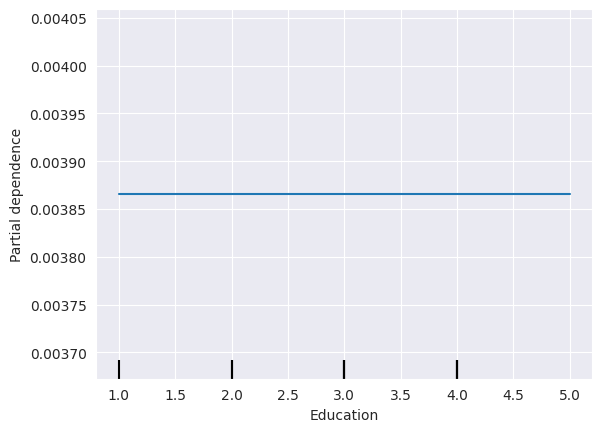

EnvironmentSatisfaction


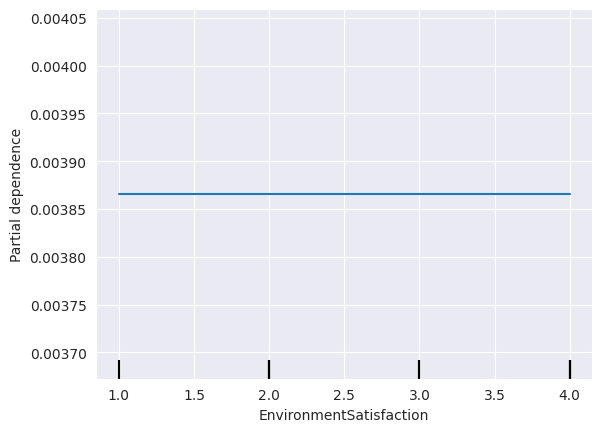

Gender


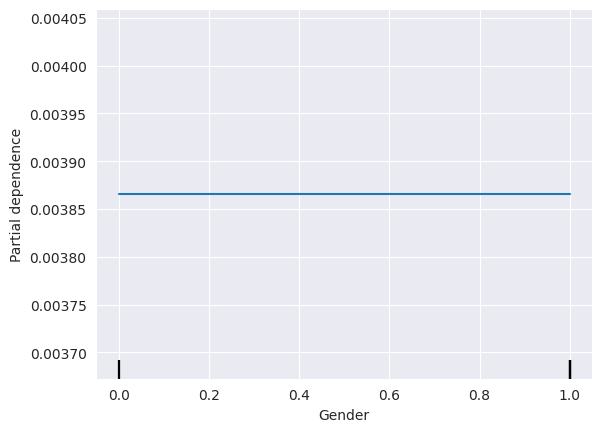

HourlyRate


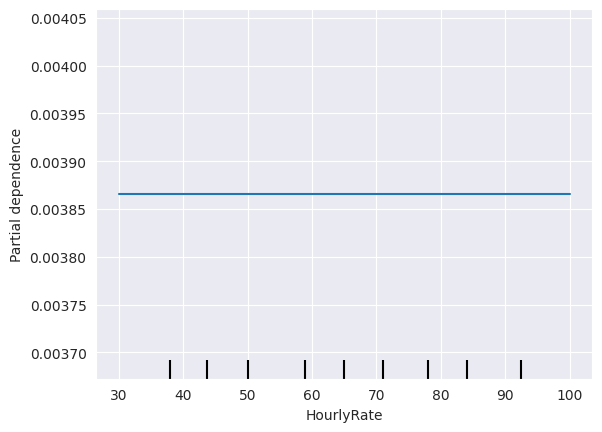

JobInvolvement


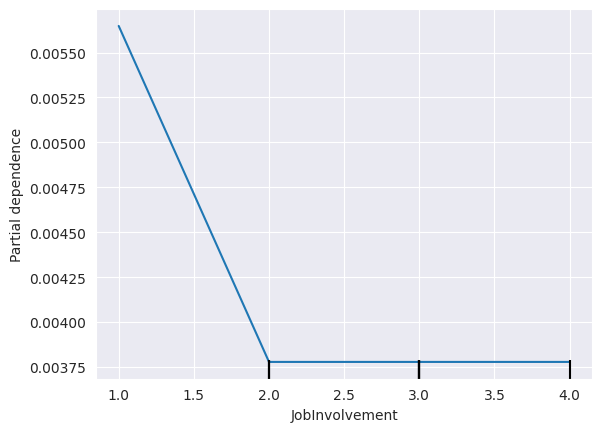

JobLevel


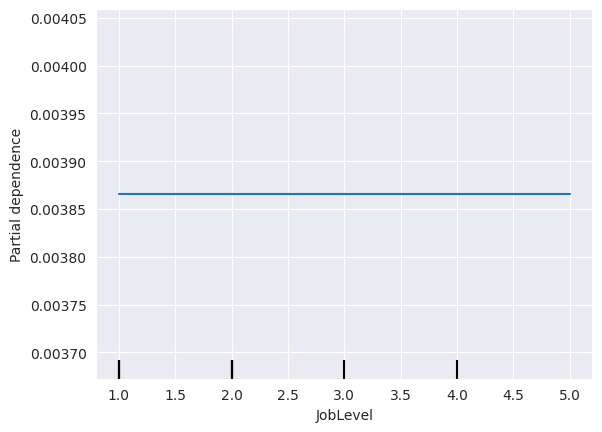

JobSatisfaction


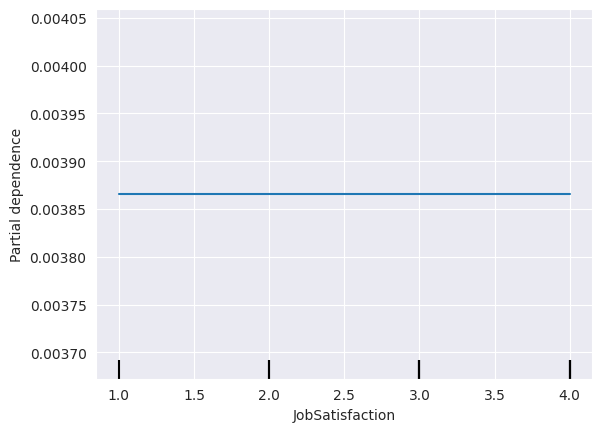

MonthlyIncome


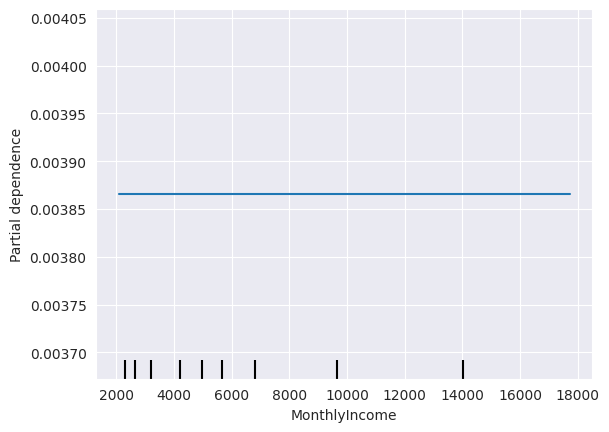

MonthlyRate


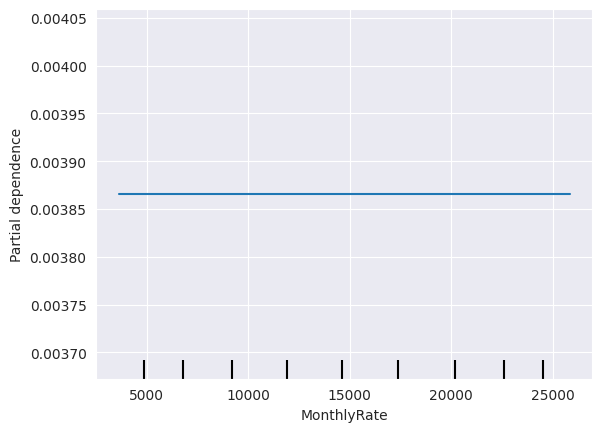

NumCompaniesWorked


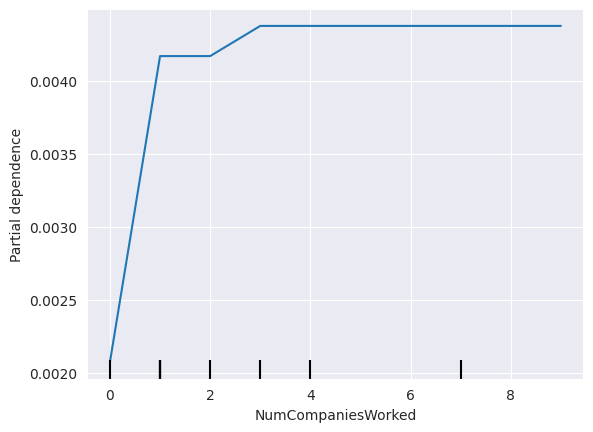

OverTime


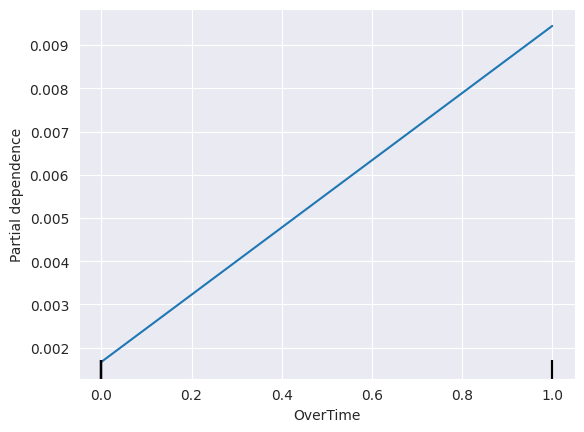

PercentSalaryHike


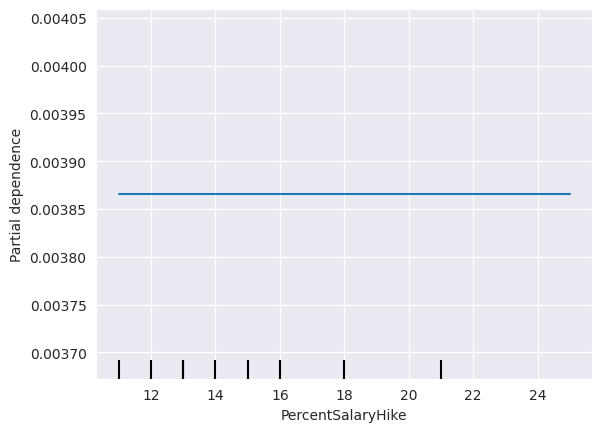

PerformanceRating


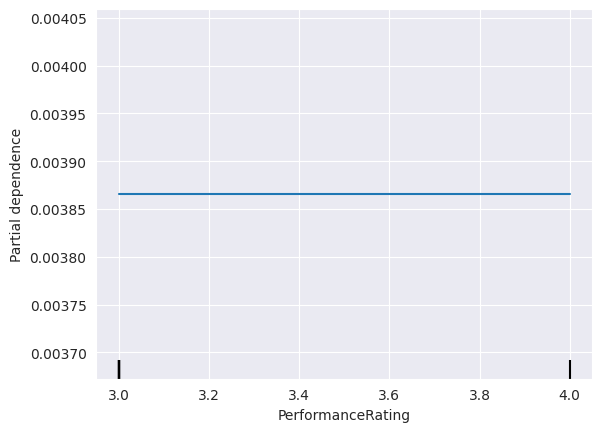

RelationshipSatisfaction


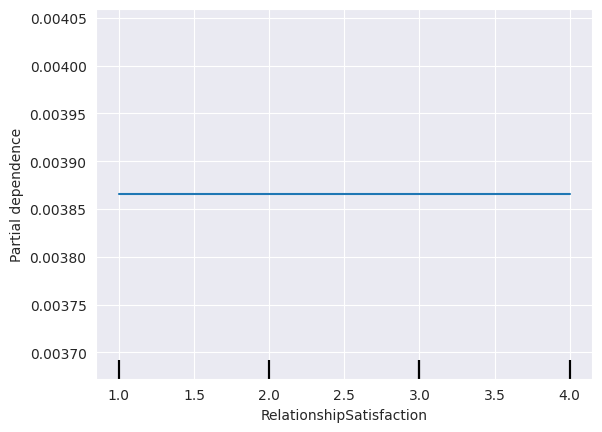

StockOptionLevel


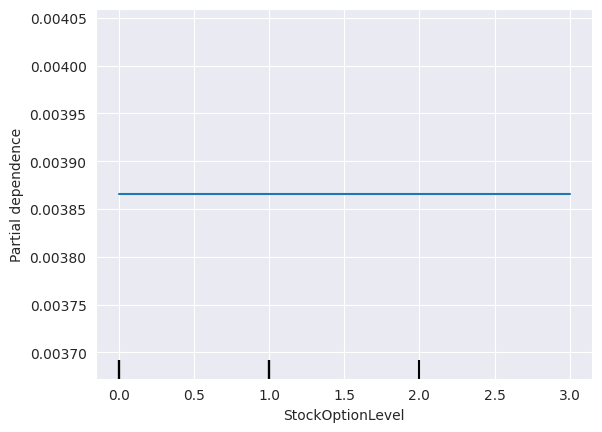

TotalWorkingYears


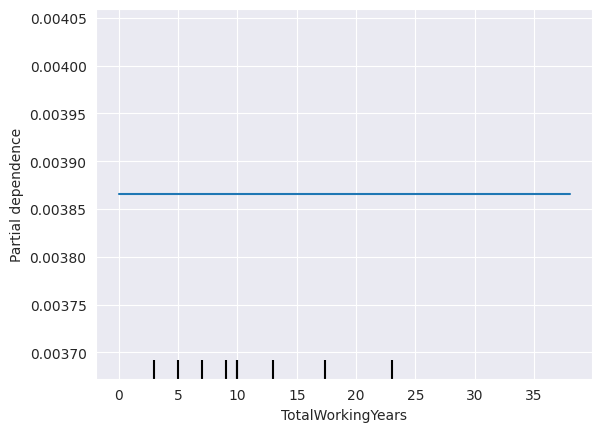

TrainingTimesLastYear


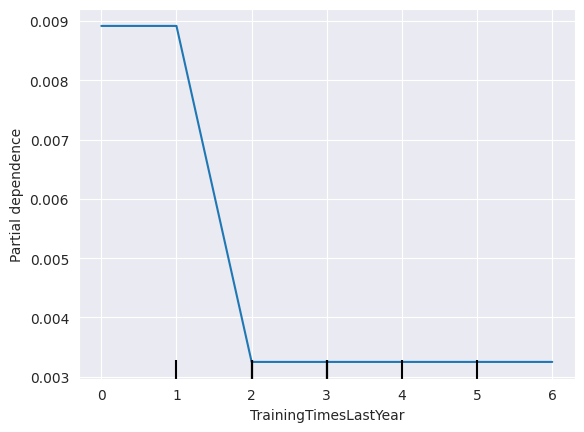

WorkLifeBalance


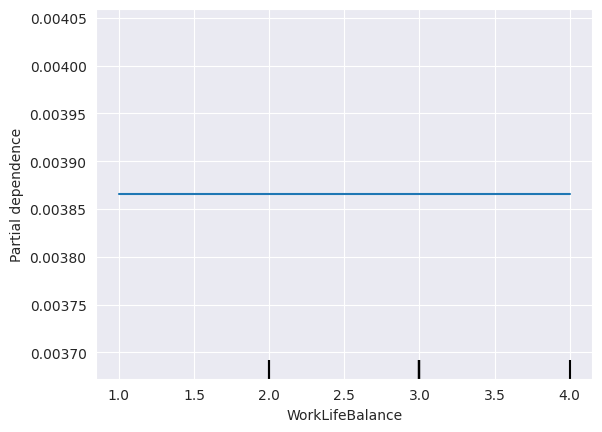

YearsAtCompany


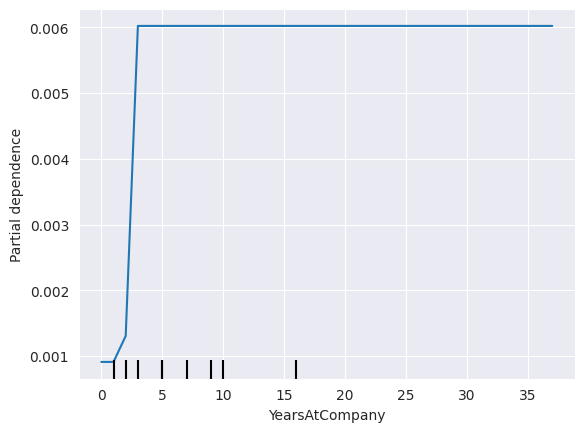

YearsInCurrentRole


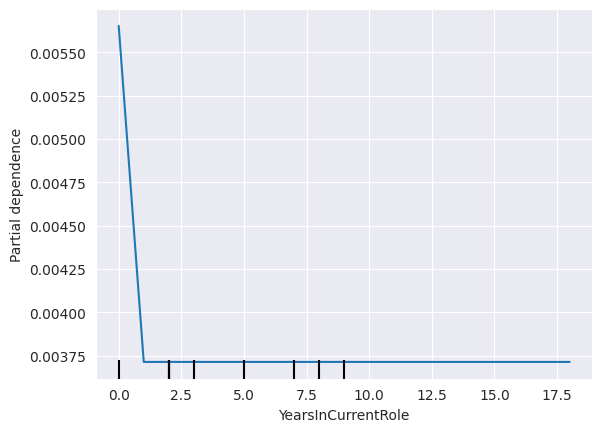

YearsSinceLastPromotion


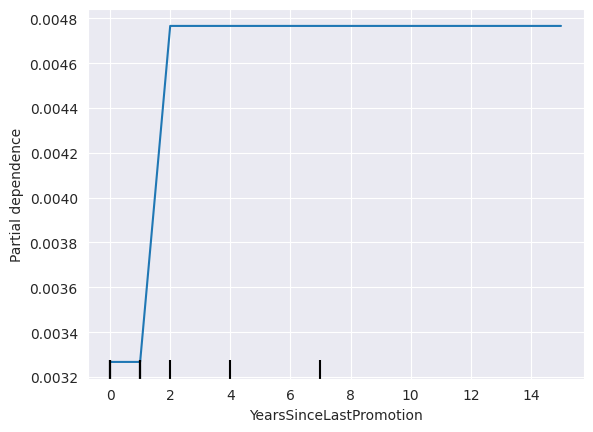

YearsWithCurrManager


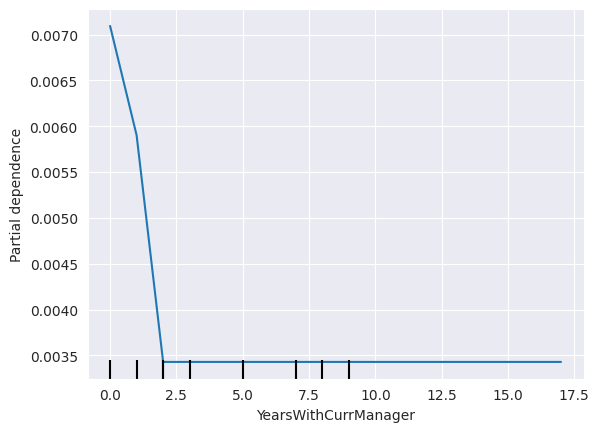

Department_Research & Development


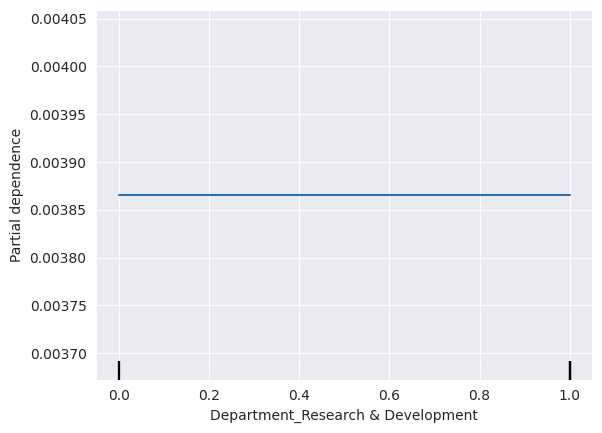

Department_Sales


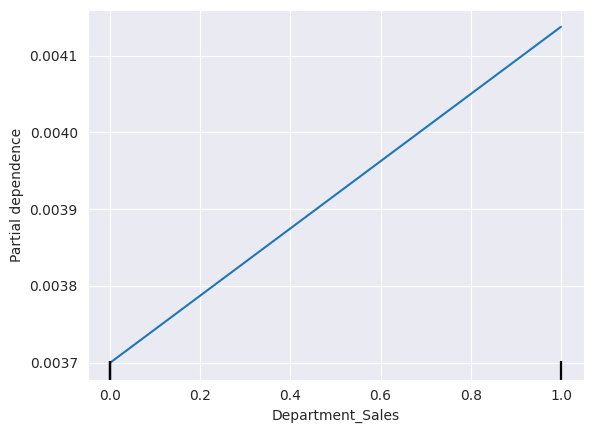

EducationField_Life Sciences


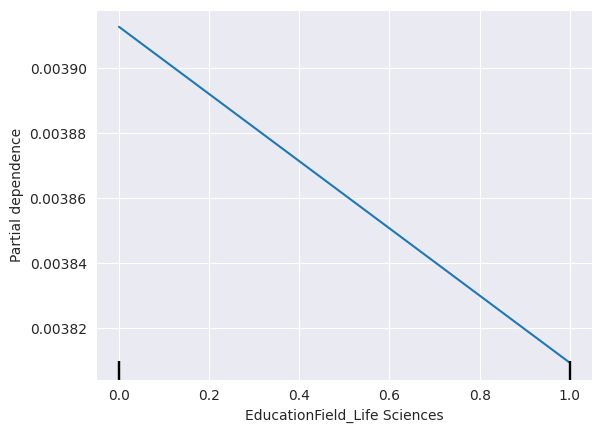

EducationField_Marketing


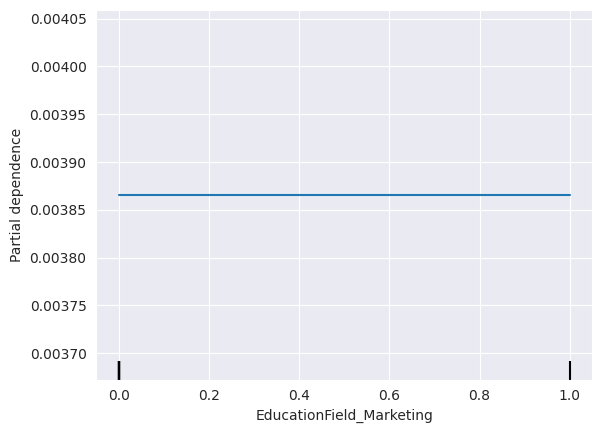

EducationField_Medical


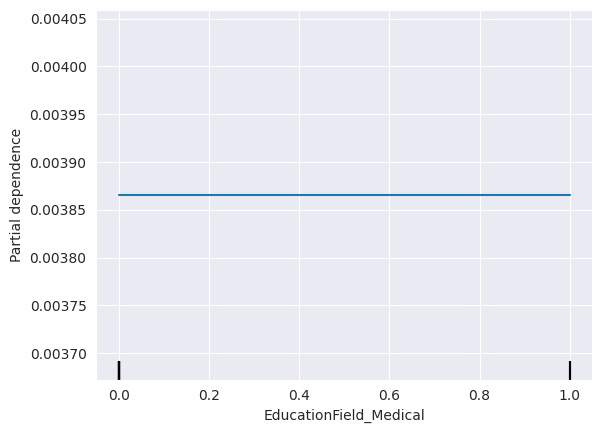

EducationField_Other


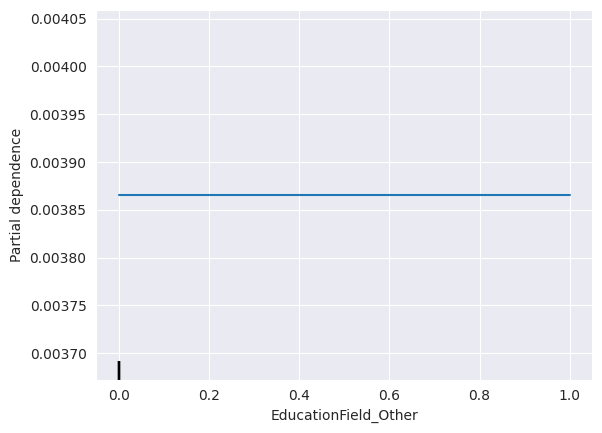

EducationField_Technical Degree


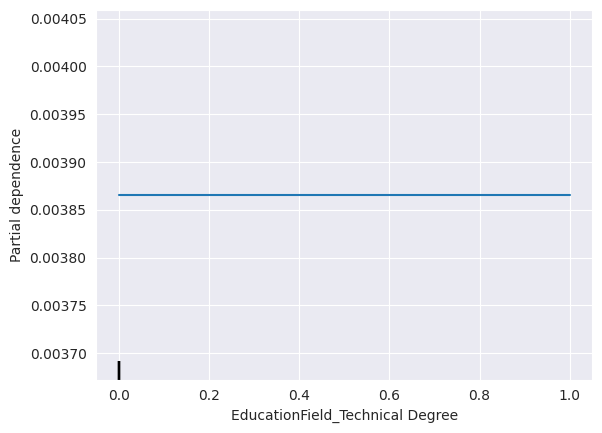

JobRole_Human Resources


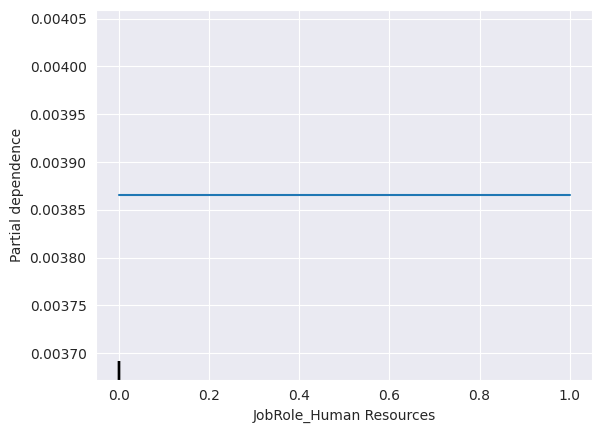

JobRole_Laboratory Technician


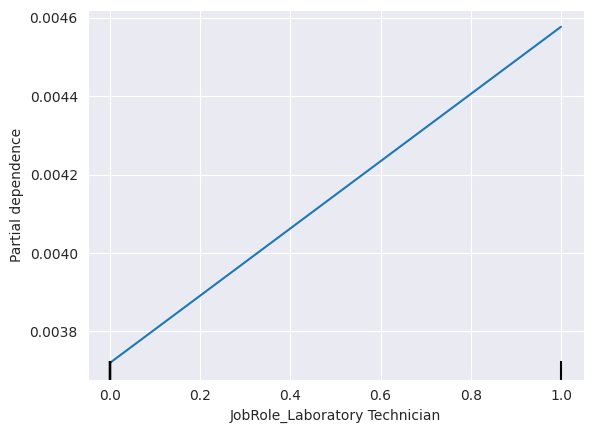

JobRole_Manager


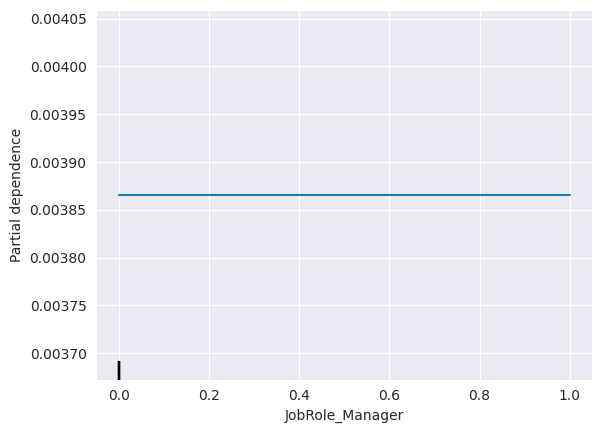

JobRole_Manufacturing Director


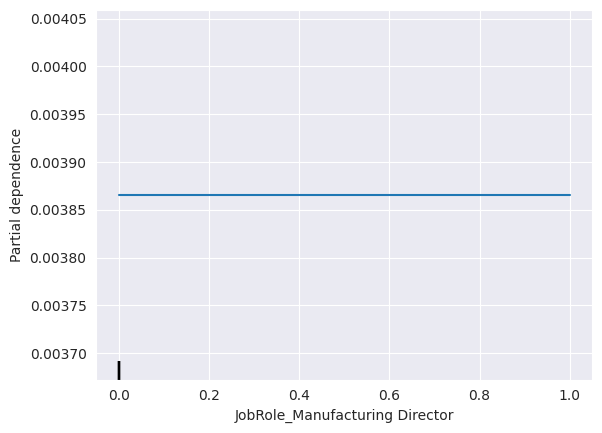

JobRole_Research Director


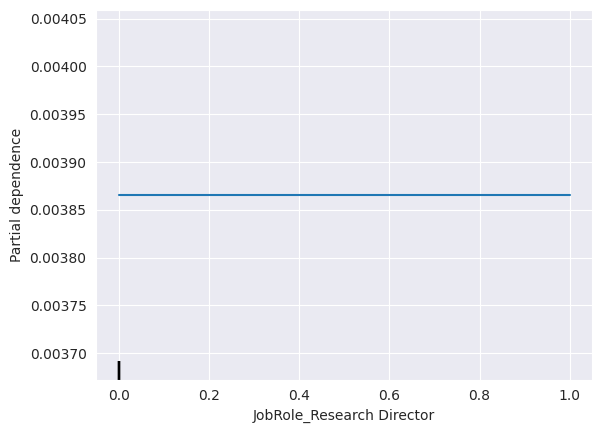

JobRole_Research Scientist


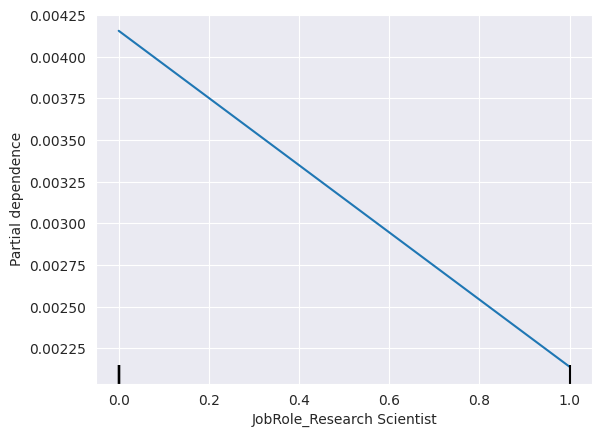

JobRole_Sales Executive


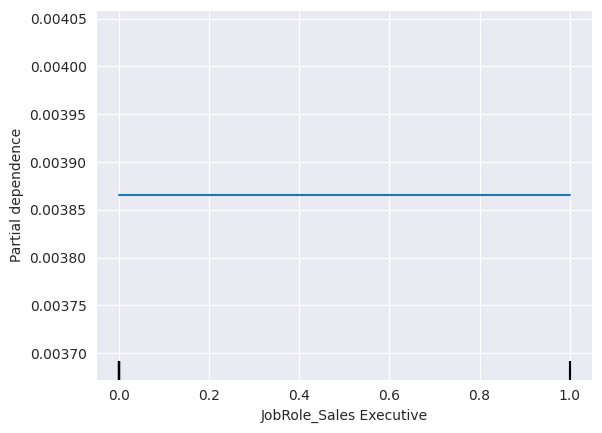

JobRole_Sales Representative


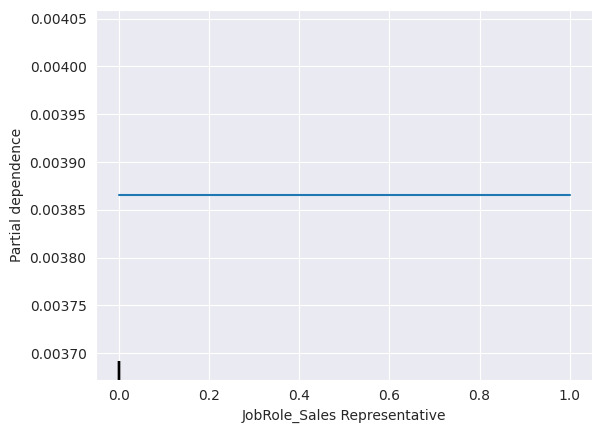

MaritalStatus_Married


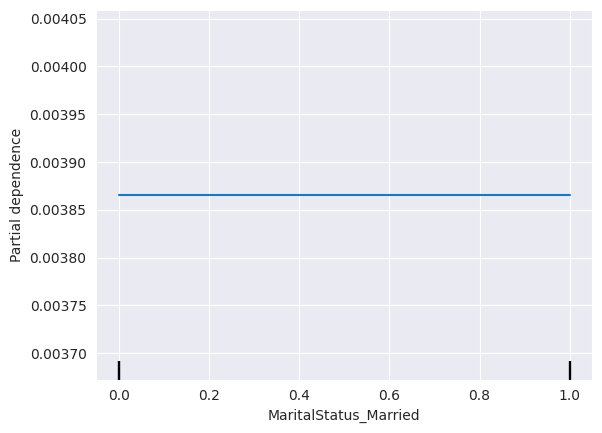

MaritalStatus_Single


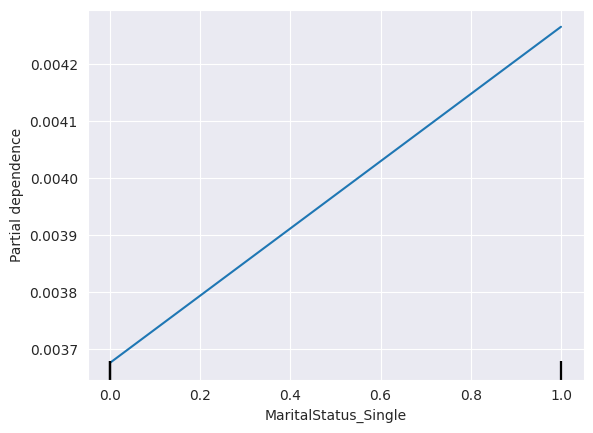

In [ ]:
# xgboost model
fig, ax = plt.subplots(figsize=(8, 6))
for feat_name in X_train.columns:
    print(feat_name)
    PartialDependenceDisplay.from_estimator(xgb, X_test, [feat_name])
    pic_name = "xgb_"+feat_name+"_dependency.png"
    plt.savefig(pic_name)
    plt.show()

# SHAP Value

In [ ]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 19.3 MB/s eta 0:00:00


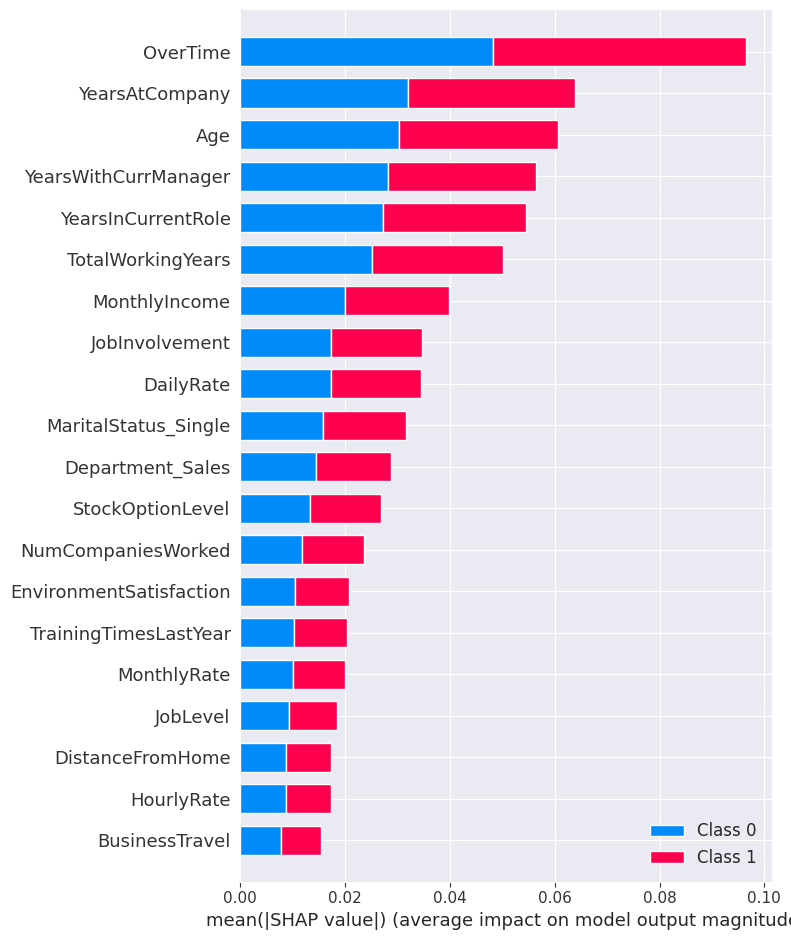

In [ ]:
import shap

# Create a TreeExplainer for your random forest model
explainer = shap.TreeExplainer(rf_scaled)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_std)

# Plot the summary plot
shap.summary_plot(shap_values, X_test_std, feature_names=X.columns, plot_type="bar")





In [ ]:
# Plot the SHAP values for a single prediction (e.g., first instance in the test set)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test_std[0], feature_names=X.columns)

In [ ]:
# Calculate the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values[0]).mean(axis=0) + np.abs(shap_values[1]).mean(axis=0)

# Create a DataFrame with feature names and mean absolute SHAP values
shap_df = pd.DataFrame(data={'Feature': X.columns, 'Mean Absolute SHAP Value': mean_shap_values})

# Sort the DataFrame by descending SHAP values
shap_df = shap_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Print the SHAP values for each variable
print(shap_df)

                              Feature  Mean Absolute SHAP Value
14                           OverTime                  0.096572
22                     YearsAtCompany                  0.063833
0                                 Age                  0.060647
25               YearsWithCurrManager                  0.056457
23                 YearsInCurrentRole                  0.054481
19                  TotalWorkingYears                  0.050115
11                      MonthlyIncome                  0.039763
8                      JobInvolvement                  0.034612
2                           DailyRate                  0.034548
42               MaritalStatus_Single                  0.031545
27                   Department_Sales                  0.028694
18                   StockOptionLevel                  0.026757
13                 NumCompaniesWorked                  0.023627
5             EnvironmentSatisfaction                  0.020690
20              TrainingTimesLastYear   

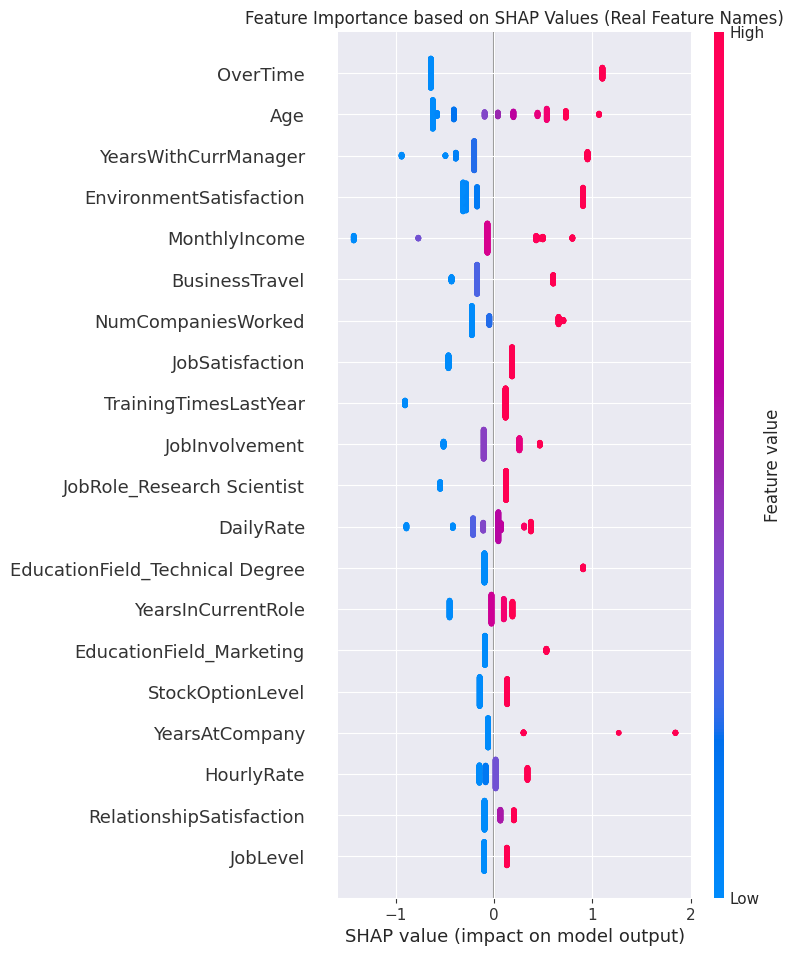

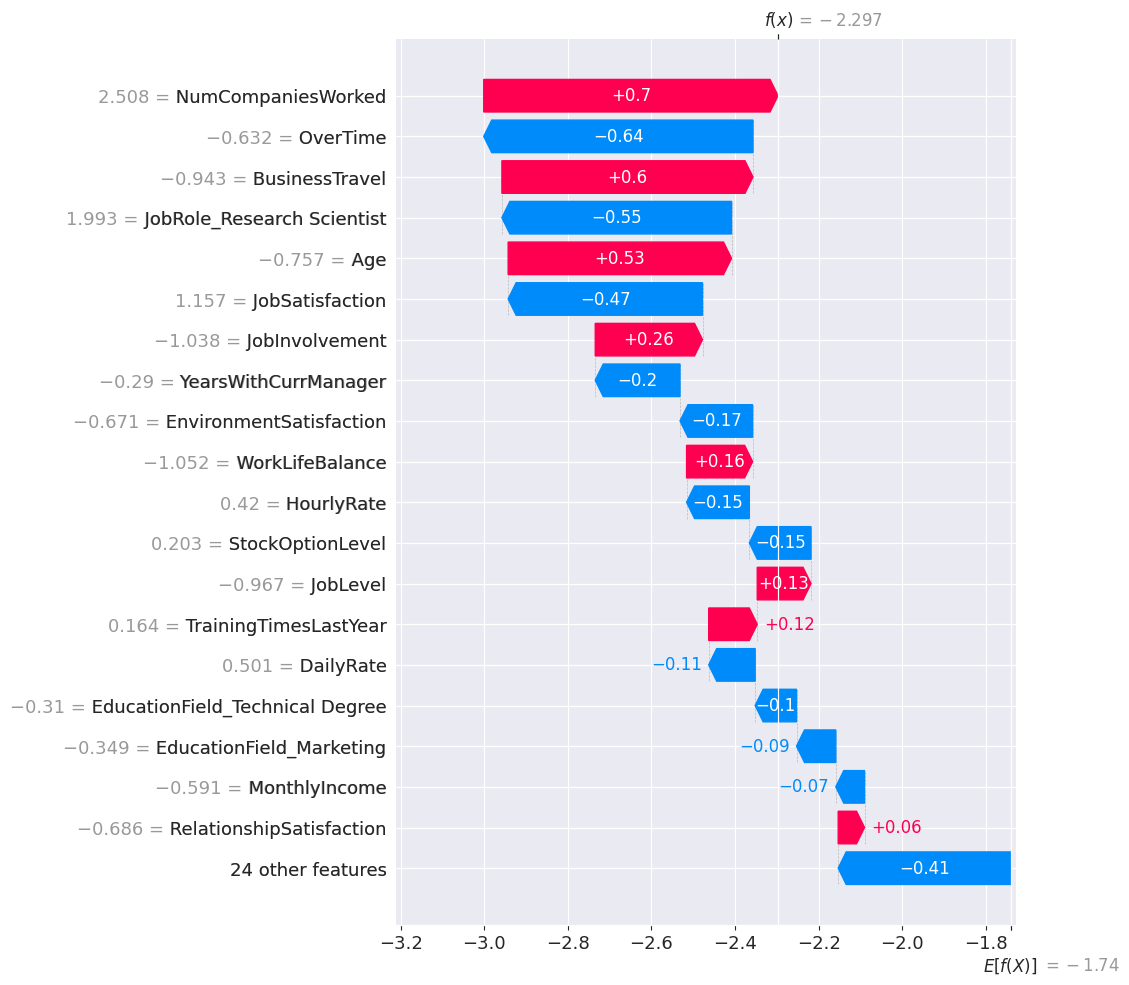

In [ ]:
import shap

# Create a TreeExplainer for your XGBoost model
explainer = shap.Explainer(xgb)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_std)

# Set the real feature names for the SHAP values object
shap_values.feature_names = X_test.columns.tolist()

shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
# Plot the summary plot with the real feature names
shap.summary_plot(shap_values.values, shap_values_df, max_display=20, show=False)
plt.title("Feature Importance based on SHAP Values (Real Feature Names)")
plt.show()

# Plot the SHAP values for a single prediction (e.g., first instance in the test set)
shap.plots.waterfall(shap_values[0], max_display=20)


# LIME

## 1.Random Forest

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_std)

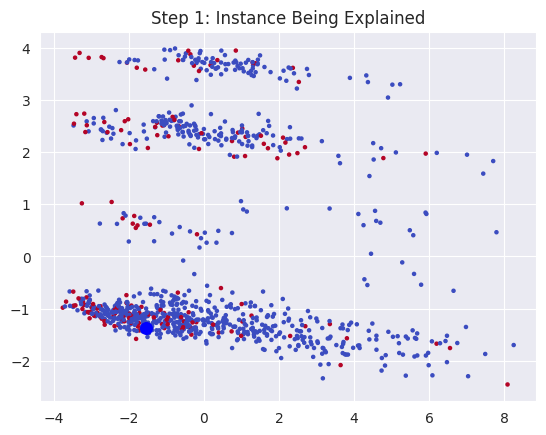

In [ ]:
# Step 1. Select an instance for which you want to explain the prediction
instance_idx = 0
Xi = X_test_std[instance_idx]
Xi_pca = pca.transform(Xi.reshape(1, -1))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap="coolwarm", s=5)
plt.scatter(Xi_pca[0, 0], Xi_pca[0, 1], c="blue", marker="o", s=70)
plt.title("Step 1: Instance Being Explained")
plt.show()

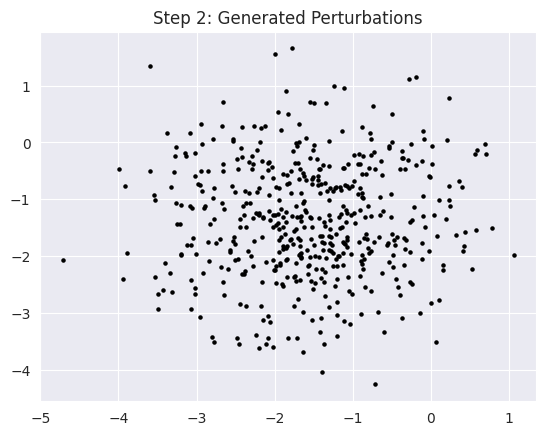

In [ ]:
# Step 2. Generate random perturbations around the instance being explained
num_perturb = 500
X_lime = np.random.normal(0, 1, size=(num_perturb, X_train_std.shape[1]))

# Adding perturbations to the selected instance
X_lime = Xi + X_lime
X_lime_pca = pca.transform(X_lime)

plt.scatter(X_lime_pca[:, 0], X_lime_pca[:, 1], s=5, c="black")
plt.title("Step 2: Generated Perturbations")
plt.show()

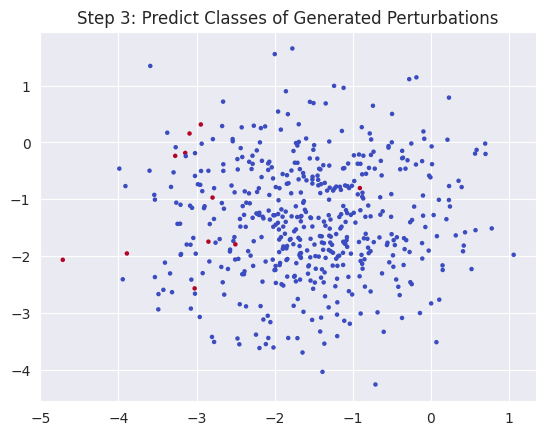

In [ ]:
# Step 3. Use the random forest model to predict classes of the new generated dataset
y_lime = rf_scaled.predict(X_lime)
plt.scatter(X_lime_pca[:, 0], X_lime_pca[:, 1], s=5, c=y_lime, cmap="coolwarm")
plt.title("Step 3: Predict Classes of Generated Perturbations")
plt.show()

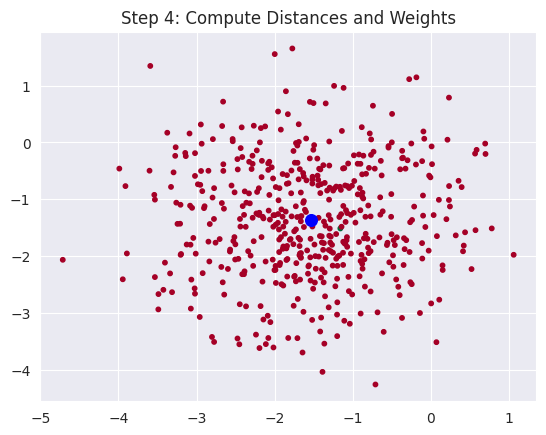

In [ ]:
# Step 4. Compute distances between the instance being explained and each perturbation and compute weights (importance) of the generated instances
from scipy.spatial.distance import euclidean

kernel_width = 0.2
distances = np.array([euclidean(Xi, x) for x in X_lime])  # Euclidean distance
weights = np.sqrt(np.exp(-(distances ** 2) / (kernel_width ** 2)))  # Kernel function

plt.scatter(X_lime_pca[:, 0], X_lime_pca[:, 1], s=10, c=weights, cmap="RdYlGn")
plt.scatter(Xi_pca[0, 0], Xi_pca[0, 1], c="blue", marker="o", s=70)
plt.title("Step 4: Compute Distances and Weights")
plt.show()

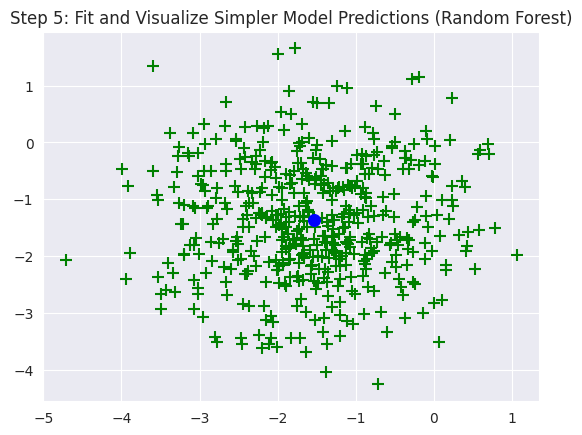

In [ ]:
# Step 5. Use the new generated dataset (X_lime), its class predictions (y_lime), and their importance (weights) to fit a simpler and interpretable (linear) model
from sklearn.linear_model import Ridge

y_lime_rf = rf_scaled.predict(X_lime)
simpler_model_rf = Ridge()
simpler_model_rf.fit(X_lime, y_lime_rf, sample_weight=weights)
y_linmodel_rf = simpler_model_rf.predict(X_lime)
y_linmodel_rf = y_linmodel_rf < 0.5  # Convert to binary class

plt.scatter(X_lime_pca[y_linmodel_rf == 0, 0], X_lime_pca[y_linmodel_rf == 0, 1], c="red", marker="_", s=80)
plt.scatter(X_lime_pca[y_linmodel_rf == 1, 0], X_lime_pca[y_linmodel_rf == 1, 1], c="green", marker="+", s=80)
plt.scatter(Xi_pca[0, 0], Xi_pca[0, 1], c="blue", marker="o", s=70)
plt.title("Step 5: Fit and Visualize Simpler Model Predictions (Random Forest)")
plt.show()

## 2. Gradient Boosting

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_std)

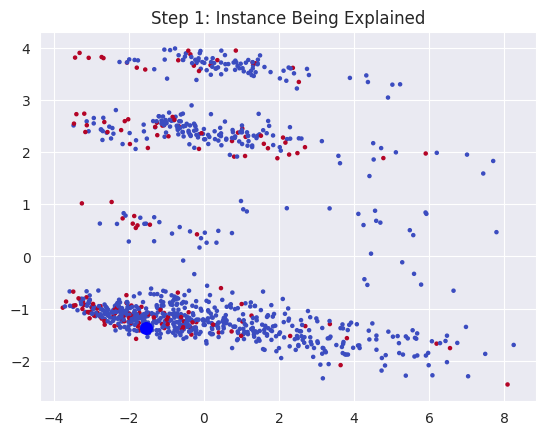

In [ ]:
# Step 1. Select an instance for which you want to explain the prediction
instance_idx = 0
Xi = X_test_std[instance_idx]
Xi_pca = pca.transform(Xi.reshape(1, -1))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap="coolwarm", s=5)
plt.scatter(Xi_pca[0, 0], Xi_pca[0, 1], c="blue", marker="o", s=70)
plt.title("Step 1: Instance Being Explained")
plt.show()

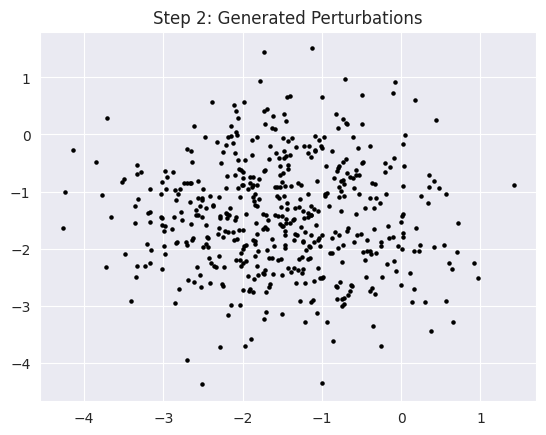

In [ ]:
# Step 2. Generate random perturbations around the instance being explained
num_perturb = 500
X_lime = np.random.normal(0, 1, size=(num_perturb, X_train_std.shape[1]))

# Adding perturbations to the selected instance
X_lime = Xi + X_lime
X_lime_pca = pca.transform(X_lime)

plt.scatter(X_lime_pca[:, 0], X_lime_pca[:, 1], s=5, c="black")
plt.title("Step 2: Generated Perturbations")
plt.show()

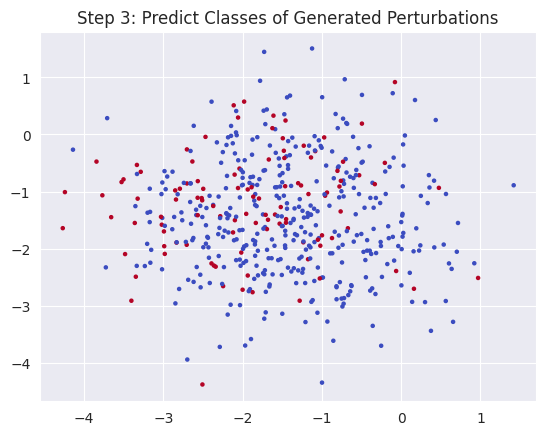

In [ ]:
# Step 3. Use the Gradient Boosting model to predict classes of new generated dataset
y_lime = xgb.predict(X_lime)
plt.scatter(X_lime_pca[:, 0], X_lime_pca[:, 1], s=5, c=y_lime, cmap="coolwarm")
plt.title("Step 3: Predict Classes of Generated Perturbations")
plt.show()

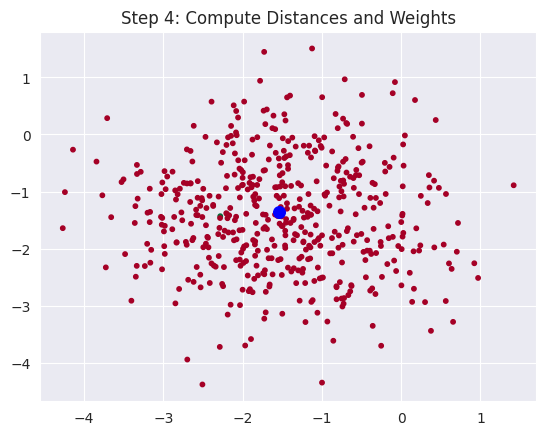

In [ ]:
# Step 4. Compute distances between the instance being explained and each perturbation and compute weights (importance) of the generated instances
from scipy.spatial.distance import euclidean

kernel_width = 0.2
distances = np.array([euclidean(Xi, x) for x in X_lime])  # Euclidean distance
weights = np.sqrt(np.exp(-(distances ** 2) / (kernel_width ** 2)))  # Kernel function

plt.scatter(X_lime_pca[:, 0], X_lime_pca[:, 1], s=10, c=weights, cmap="RdYlGn")
plt.scatter(Xi_pca[0, 0], Xi_pca[0, 1], c="blue", marker="o", s=70)
plt.title("Step 4: Compute Distances and Weights")
plt.show()

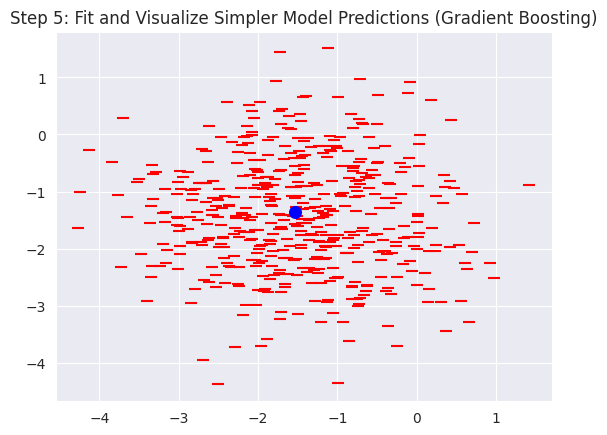

In [ ]:
# Step 5. Use the new generated dataset (X_lime), its class predictions (y_lime), and their importance (weights) to fit a simpler and interpretable (linear) model
from sklearn.linear_model import Ridge

simpler_model = Ridge()
simpler_model.fit(X_lime, y_lime, sample_weight=weights)
y_linmodel = simpler_model.predict(X_lime)
y_linmodel = y_linmodel < 0.5  # Convert to binary class

plt.scatter(X_lime_pca[y_linmodel == 0, 0], X_lime_pca[y_linmodel == 0, 1], c="red", marker="_", s=80)
plt.scatter(X_lime_pca[y_linmodel == 1, 0], X_lime_pca[y_linmodel == 1, 1], c="green", marker="+", s=80)
plt.scatter(Xi_pca[0, 0], Xi_pca[0, 1], c="blue", marker="o", s=70)
plt.title("Step 5: Fit and Visualize Simpler Model Predictions (Gradient Boosting)")
plt.show()

# **Counterfactuals Explanations**

In [ ]:
!pip install dice_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 49.3 MB/s eta 0:00:00


In [ ]:
import dice_ml
from dice_ml.utils import helpers

In [ ]:
num_cols = df._get_numeric_data().columns
num_cols = list(num_cols)

In [ ]:
target = df["Attrition"]
train_dataset, test_dataset, y_train, y_test = train_test_split(df,
                                                                target,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=target)
x_train = train_dataset.drop('Attrition', axis=1)
x_test = test_dataset.drop('Attrition', axis=1)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

categorical = x_train.columns.difference(num_cols)

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier(n_estimators = 100, # number of trees
    max_depth= 5,       # parameters for the individual trees
    oob_score = True,   # whether or not to compute OOB score
    random_state = 0,
    class_weight = 'balanced'))])

model = clf.fit(x_train, y_train)

In [ ]:
# Step 1: dice_ml.Data
d = dice_ml.Data(dataframe=train_dataset, continuous_features=num_cols, outcome_name='Attrition')

In [ ]:
# Using sklearn backend
m = dice_ml.Model(model=model, backend="sklearn")
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="random")

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
features_to_vary = ['OverTime','MonthlyIncome']
e1 = exp.generate_counterfactuals(x_test[53:54], total_CFs=2, desired_class="opposite",features_to_vary = features_to_vary)
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

Query instance (original outcome : 1)


Age BusinessTravel  DailyRate              Department  DistanceFromHome  \
0   38     Non-Travel        573  Research & Development                 6   

   Education EducationField  EnvironmentSatisfaction  Gender  HourlyRate  \
0          3        Medical                        2  Female          79   

   JobInvolvement  JobLevel             JobRole  JobSatisfaction  \
0               1         2  Research Scientist                4   

  MaritalStatus  MonthlyIncome  MonthlyRate  NumCompaniesWorked OverTime  \
0      Divorced           5329        15717                   7      Yes   

   PercentSalaryHike  PerformanceRating  RelationshipSatisfaction  \
0                 12                  3                         4   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
0                 3                 17                      3   

   WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
0                3              13                  11   

   YearsSinceLastPromotion  YearsWithCurrManager  Attrition  
0                        1                     9          1


Diverse Counterfactual set (new outcome: 0.0)


Age BusinessTravel DailyRate Department DistanceFromHome Education  \
0   -              -         -          -                -         -   
1   -              -         -          -                -         -   

  EducationField EnvironmentSatisfaction Gender HourlyRate JobInvolvement  \
0              -                       -      -          -              -   
1              -                       -      -          -              -   

  JobLevel JobRole JobSatisfaction MaritalStatus MonthlyIncome MonthlyRate  \
0        -       -               -             -       10746.0           -   
1        -       -               -             -       10713.0           -   

  NumCompaniesWorked OverTime PercentSalaryHike PerformanceRating  \
0                  -       No                 -                 -   
1                  -       No                 -                 -   

  RelationshipSatisfaction StockOptionLevel TotalWorkingYears  \
0                        -                -                 -   
1                        -                -                 -   

  TrainingTimesLastYear WorkLifeBalance YearsAtCompany YearsInCurrentRole  \
0                     -               -              -                  -   
1                     -               -              -                  -   

  YearsSinceLastPromotion YearsWithCurrManager Attrition  
0                       -                    -         0  
1                       -                    -         0

In [ ]:
class_map = {'Yes':1,'No':0}
y_train = y_train.map(class_map)

In [ ]:
xgb_clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', XGBClassifier(
    n_estimators = 500,   # Number of trees i.e. number of boosting steps to take
    learning_rate = 0.1,  # Learning rate. Set this to a small number to grow trees slowly.
    max_depth = 1,        # Parameters for the individual trees
    random_state= 22
))])
xgb_model = xgb_clf.fit(x_train, y_train)

In [ ]:
# Using sklearn backend
m_xgb = dice_ml.Model(model=xgb_model, backend="sklearn")
# Using method=random for generating CFs
exp_xgb  = dice_ml.Dice(d, m_xgb, method="random")

In [ ]:
features_to_vary = ['OverTime','MonthlyIncome','DailyRate','Department','HourlyRate','PercentSalaryHike','WorkLifeBalance']
e1_xgb = exp_xgb.generate_counterfactuals(x_test[215:216], total_CFs=2, desired_class="opposite",features_to_vary = features_to_vary)
e1_xgb.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

Query instance (original outcome : 1)


Age     BusinessTravel  DailyRate Department  DistanceFromHome  Education  \
0   35  Travel_Frequently        880      Sales                12          4   

  EducationField  EnvironmentSatisfaction Gender  HourlyRate  JobInvolvement  \
0          Other                        4   Male          36               3   

   JobLevel          JobRole  JobSatisfaction MaritalStatus  MonthlyIncome  \
0         2  Sales Executive                4        Single           4581   

   MonthlyRate  NumCompaniesWorked OverTime  PercentSalaryHike  \
0        10414                   3      Yes                 24   

   PerformanceRating  RelationshipSatisfaction  StockOptionLevel  \
0                  4                         1                 0   

   TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
0                 13                      2                4              11   

   YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  \
0                   9                        6                     7   

   Attrition  
0          1


Diverse Counterfactual set (new outcome: 0.0)


Age BusinessTravel DailyRate Department DistanceFromHome Education  \
0   -              -         -          -                -         -   
1   -              -         -          -                -         -   

  EducationField EnvironmentSatisfaction Gender HourlyRate JobInvolvement  \
0              -                       -      -       53.0              -   
1              -                       -      -       50.0              -   

  JobLevel JobRole JobSatisfaction MaritalStatus MonthlyIncome MonthlyRate  \
0        -       -               -             -             -           -   
1        -       -               -             -             -           -   

  NumCompaniesWorked OverTime PercentSalaryHike PerformanceRating  \
0                  -       No                 -                 -   
1                  -       No                 -                 -   

  RelationshipSatisfaction StockOptionLevel TotalWorkingYears  \
0                        -                -                 -   
1                        -                -                 -   

  TrainingTimesLastYear WorkLifeBalance YearsAtCompany YearsInCurrentRole  \
0                     -               -              -                  -   
1                     -               -              -                  -   

  YearsSinceLastPromotion YearsWithCurrManager Attrition  
0                       -                    -         0  
1                       -                    -         0